<img src="../img/logo_amds.png" alt="Logo" style="width: 128px;"/>

# AmsterdamUMCdb - Freely Accessible ICU Database

version 1.0.1 January 2020  
Copyright &copy; 2003-2020 Amsterdam UMC - Amsterdam Medical Data Science

# <a id='listitems'></a>listitems table
The *listitems* table contains all categorical observations, e.g. based on a selection from a list, like type of heart rhytm, ventilatory mode, etc. All items have an associated admissionid from the [admissions](admissions.ipynb#admissions) table.

This table also contains the [reason for ICU admission](#apache), according to the APACHE II or IV diagnostic codes.

## Fields

|Name|Type|Description|
|:---|:---|:---|
|admissionid|integer|links the items with the admissionid in the [admissions](admissions.ipynb#admissions) table|
|[itemid](#itemid)|integer|id to identify the type of observation|
|[item](#item)|string|type of observation|
|[value](#value)|string|value of this observation|
|measuredat|integer|time associated with this observation in milliseconds since the first admission. Negative results imply that the sample was drawn before the first ICU admission|
|registeredat|integer|time the result was saved in the database in milliseconds since the first admission. Negative results imply that the sample was drawn before the first ICU admission.|
|registeredby|string|user group that documented the observation, e.g. nurses, physicians or NULL for linked devices|
|updatedat|integer|time of updating the observation in milliseconds since first admission|
|updatedby|string|user group that documented the observation, e.g. nurses, physicians or NULL for linked devices|
|islabresult|boolean|determines whether the observation is a labresult. Currently, only item 'Afnameplaats' is a labresult, used to determine the location of sample drawing during down-time of the lab or hospital system.|

# Example Python and SQL scripts

## Imports

In [1]:
%matplotlib inline
import amsterdamumcdb
import psycopg2
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

import io
from IPython.display import display, HTML, Markdown

## Display settings

In [2]:
#matplotlib settings for image size
#needs to be in a different cell from %matplotlib inline
plt.style.use('seaborn-darkgrid')
plt.rcParams["figure.dpi"] = 288
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["font.size"] = 12

pd.options.display.max_columns = None
pd.options.display.max_rows = 20
pd.options.display.max_colwidth = 1000

## Connection settings

In [3]:
#Modify config.ini in the root folder of the repository to change the settings to connect to your postgreSQL database
import configparser
import os
config = configparser.ConfigParser()

if os.path.isfile('../config.ini'):
    config.read('../config.ini')
else:
    config.read('../config.SAMPLE.ini')

#Open a connection to the postgres database:
con = psycopg2.connect(database=config['psycopg2']['database'], 
                       user=config['psycopg2']['username'], password=config['psycopg2']['password'], 
                       host=config['psycopg2']['host'], port=config['psycopg2']['port'])
con.set_client_encoding('WIN1252') #Uses code page for Dutch accented characters.
con.set_session(autocommit=True)

cursor = con.cursor()
cursor.execute('SET SCHEMA \'amsterdamumcdb\''); #set search_path to amsterdamumcdb schema

## Overview of all fields

In [4]:
sql = """
SELECT * FROM listitems LIMIT 10;
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df

``` mysql

SELECT * FROM listitems LIMIT 10;

```

,admissionid,itemid,item,valueid,value,measuredat,registeredat,registeredby,updatedat,updatedby,islabresult
0,0,6671,Hartritme,1,NSR,20520000,21480000,ICV_IC-Verpleegkundig,21480000,ICV_IC-Verpleegkundig,0
1,0,6671,Hartritme,1,NSR,22320000,29400000,ICV_IC-Verpleegkundig,29400000,ICV_IC-Verpleegkundig,0
2,0,6671,Hartritme,1,NSR,25920000,29460000,ICV_IC-Verpleegkundig,29460000,ICV_IC-Verpleegkundig,0
3,0,6671,Hartritme,1,NSR,29520000,29460000,ICV_IC-Verpleegkundig,29460000,ICV_IC-Verpleegkundig,0
4,0,6671,Hartritme,1,NSR,33120000,33300000,ICV_IC-Verpleegkundig,33300000,ICV_IC-Verpleegkundig,0
5,0,6671,Hartritme,1,NSR,36720000,36960000,ICV_IC-Verpleegkundig,36960000,ICV_IC-Verpleegkundig,0
6,0,6671,Hartritme,1,NSR,40320000,40440000,ICV_IC-Verpleegkundig,40440000,ICV_IC-Verpleegkundig,0
7,0,6671,Hartritme,1,NSR,43920000,45540000,ICV_IC-Verpleegkundig,45540000,ICV_IC-Verpleegkundig,0
8,0,6671,Hartritme,1,NSR,51120000,51300000,ICV_IC-Verpleegkundig,51300000,ICV_IC-Verpleegkundig,0
9,0,6671,Hartritme,1,NSR,58320000,62700000,ICV_IC-Verpleegkundig,62700000,ICV_IC-Verpleegkundig,0


In [5]:
sql = """
SELECT COUNT(*) AS "Number of unique observations" FROM (
    SELECT DISTINCT admissionid, itemid, measuredat
    FROM listitems
    ) as unique_items_table
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df

``` mysql

SELECT COUNT(*) AS "Number of unique observations" FROM (
    SELECT DISTINCT admissionid, itemid, measuredat
    FROM listitems
    ) as unique_items_table

```

,Number of unique observations
0,29935545


In [6]:
sql = """
SELECT COUNT(*) AS "Number of observations" 
FROM listitems
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df

``` mysql

SELECT COUNT(*) AS "Number of observations" 
FROM listitems

```

,Number of observations
0,31072879


## <a id='itemid'></a>itemid

In [7]:
sql = """
SELECT admissionid, itemid, measuredat, value
FROM listitems
GROUP BY admissionid, itemid, measuredat, value
HAVING COUNT(*) > 1
LIMIT 5
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df

``` mysql

SELECT admissionid, itemid, measuredat, value
FROM listitems
GROUP BY admissionid, itemid, measuredat, value
HAVING COUNT(*) > 1
LIMIT 5

```

,admissionid,itemid,measuredat,value
0,0,12611,20520000,14
1,0,12623,20520000,21
2,0,12810,20520000,Standaard matras
3,0,12810,58320000,Standaard matras
4,0,12810,144720000,Standaard matras


In [8]:
sql = """
SELECT *
FROM listitems t1
JOIN (
    SELECT admissionid, itemid, measuredat
    FROM listitems
    GROUP BY admissionid, itemid, measuredat
    HAVING COUNT(*) > 1
    ) t2 
ON t1.admissionid = t2.admissionid AND t1.itemid = t2.itemid AND t1.measuredat = t2.measuredat
ORDER BY t1.admissionid, t1.itemid, t1.measuredat
LIMIT 10
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df

``` mysql

SELECT *
FROM listitems t1
JOIN (
    SELECT admissionid, itemid, measuredat
    FROM listitems
    GROUP BY admissionid, itemid, measuredat
    HAVING COUNT(*) > 1
    ) t2 
ON t1.admissionid = t2.admissionid AND t1.itemid = t2.itemid AND t1.measuredat = t2.measuredat
ORDER BY t1.admissionid, t1.itemid, t1.measuredat
LIMIT 10

```

,admissionid,itemid,item,valueid,value,measuredat,registeredat,registeredby,updatedat,updatedby,islabresult,admissionid,itemid,measuredat
0,0,6671,Hartritme,1,NSR,126720000,133680000,ICV_IC-Verpleegkundig,133680000,ICV_IC-Verpleegkundig,0,0,6671,126720000
1,0,6671,Hartritme,22,SVT,126720000,133680000,ICV_IC-Verpleegkundig,133680000,ICV_IC-Verpleegkundig,0,0,6671,126720000
2,0,12611,Sonde maat,1,14,20520000,22620000,ICV_IC-Verpleegkundig,22620000,ICV_IC-Verpleegkundig,0,0,12611,20520000
3,0,12611,Sonde maat,1,14,20520000,22644000,ICV_IC-Verpleegkundig,22644000,ICV_IC-Verpleegkundig,0,0,12611,20520000
4,0,12623,Tube diepte,3,21,20520000,22620000,ICV_IC-Verpleegkundig,22620000,ICV_IC-Verpleegkundig,0,0,12623,20520000
5,0,12623,Tube diepte,3,21,20520000,22668000,ICV_IC-Verpleegkundig,22668000,ICV_IC-Verpleegkundig,0,0,12623,20520000
6,0,12810,Bedsoort,1,Standaard matras,20520000,22680000,ICV_IC-Verpleegkundig,22680000,ICV_IC-Verpleegkundig,0,0,12810,20520000
7,0,12810,Bedsoort,1,Standaard matras,20520000,22691000,ICV_IC-Verpleegkundig,22691000,ICV_IC-Verpleegkundig,0,0,12810,20520000
8,0,12810,Bedsoort,1,Standaard matras,58320000,58440000,ICV_IC-Verpleegkundig,58440000,ICV_IC-Verpleegkundig,0,0,12810,58320000
9,0,12810,Bedsoort,1,Standaard matras,58320000,58478000,ICV_IC-Verpleegkundig,58478000,ICV_IC-Verpleegkundig,0,0,12810,58320000


In [9]:
sql = """
SELECT *
FROM listitems
WHERE admissionid = 2863 AND
    itemid = 8895 AND
    measuredat = 4016700000;
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df

``` mysql

SELECT *
FROM listitems
WHERE admissionid = 2863 AND
    itemid = 8895 AND
    measuredat = 4016700000;

```

,admissionid,itemid,item,valueid,value,measuredat,registeredat,registeredby,updatedat,updatedby,islabresult
0,2863,8895,Kleur Sputum,6,Purulent,4016700000,4033140000,ICV_IC-Verpleegkundig,4033140000,ICV_IC-Verpleegkundig,0
1,2863,8895,Kleur Sputum,9,Spoor bloed,4016700000,4033140000,ICV_IC-Verpleegkundig,4033140000,ICV_IC-Verpleegkundig,0


## <a id='item'></a>item

In [10]:
sql = """
SELECT item, COUNT(itemid) AS "number of observations", itemid
FROM listitems
GROUP BY item, itemid
ORDER BY "number of observations" DESC
LIMIT 20; 
"""
import matplotlib as mpl
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df

``` mysql

SELECT item, COUNT(itemid) AS "number of observations", itemid
FROM listitems
GROUP BY item, itemid
ORDER BY "number of observations" DESC
LIMIT 20; 

```

,item,number of observations,itemid
0,Ventilatie Mode (Set),15703369,12290
1,MFT_Behandeling,2186881,14846
2,Hartritme,2054619,6671
3,Houding patiënt,1081571,9233
4,Toedieningsweg,661671,8189
5,NIV Program Status (Set),375439,12560
6,Kleur Sputum,369756,8895
7,Aantal Bronchiaaltoilet,289388,8889
8,Hoeveelheid Sputum,270172,8894
9,Hoestprikkel,258805,8899


``` mysql

SELECT item, COUNT(itemid) AS "number of observations", itemid
FROM listitems
GROUP BY item, itemid
ORDER BY "number of observations" DESC
LIMIT 20

```

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

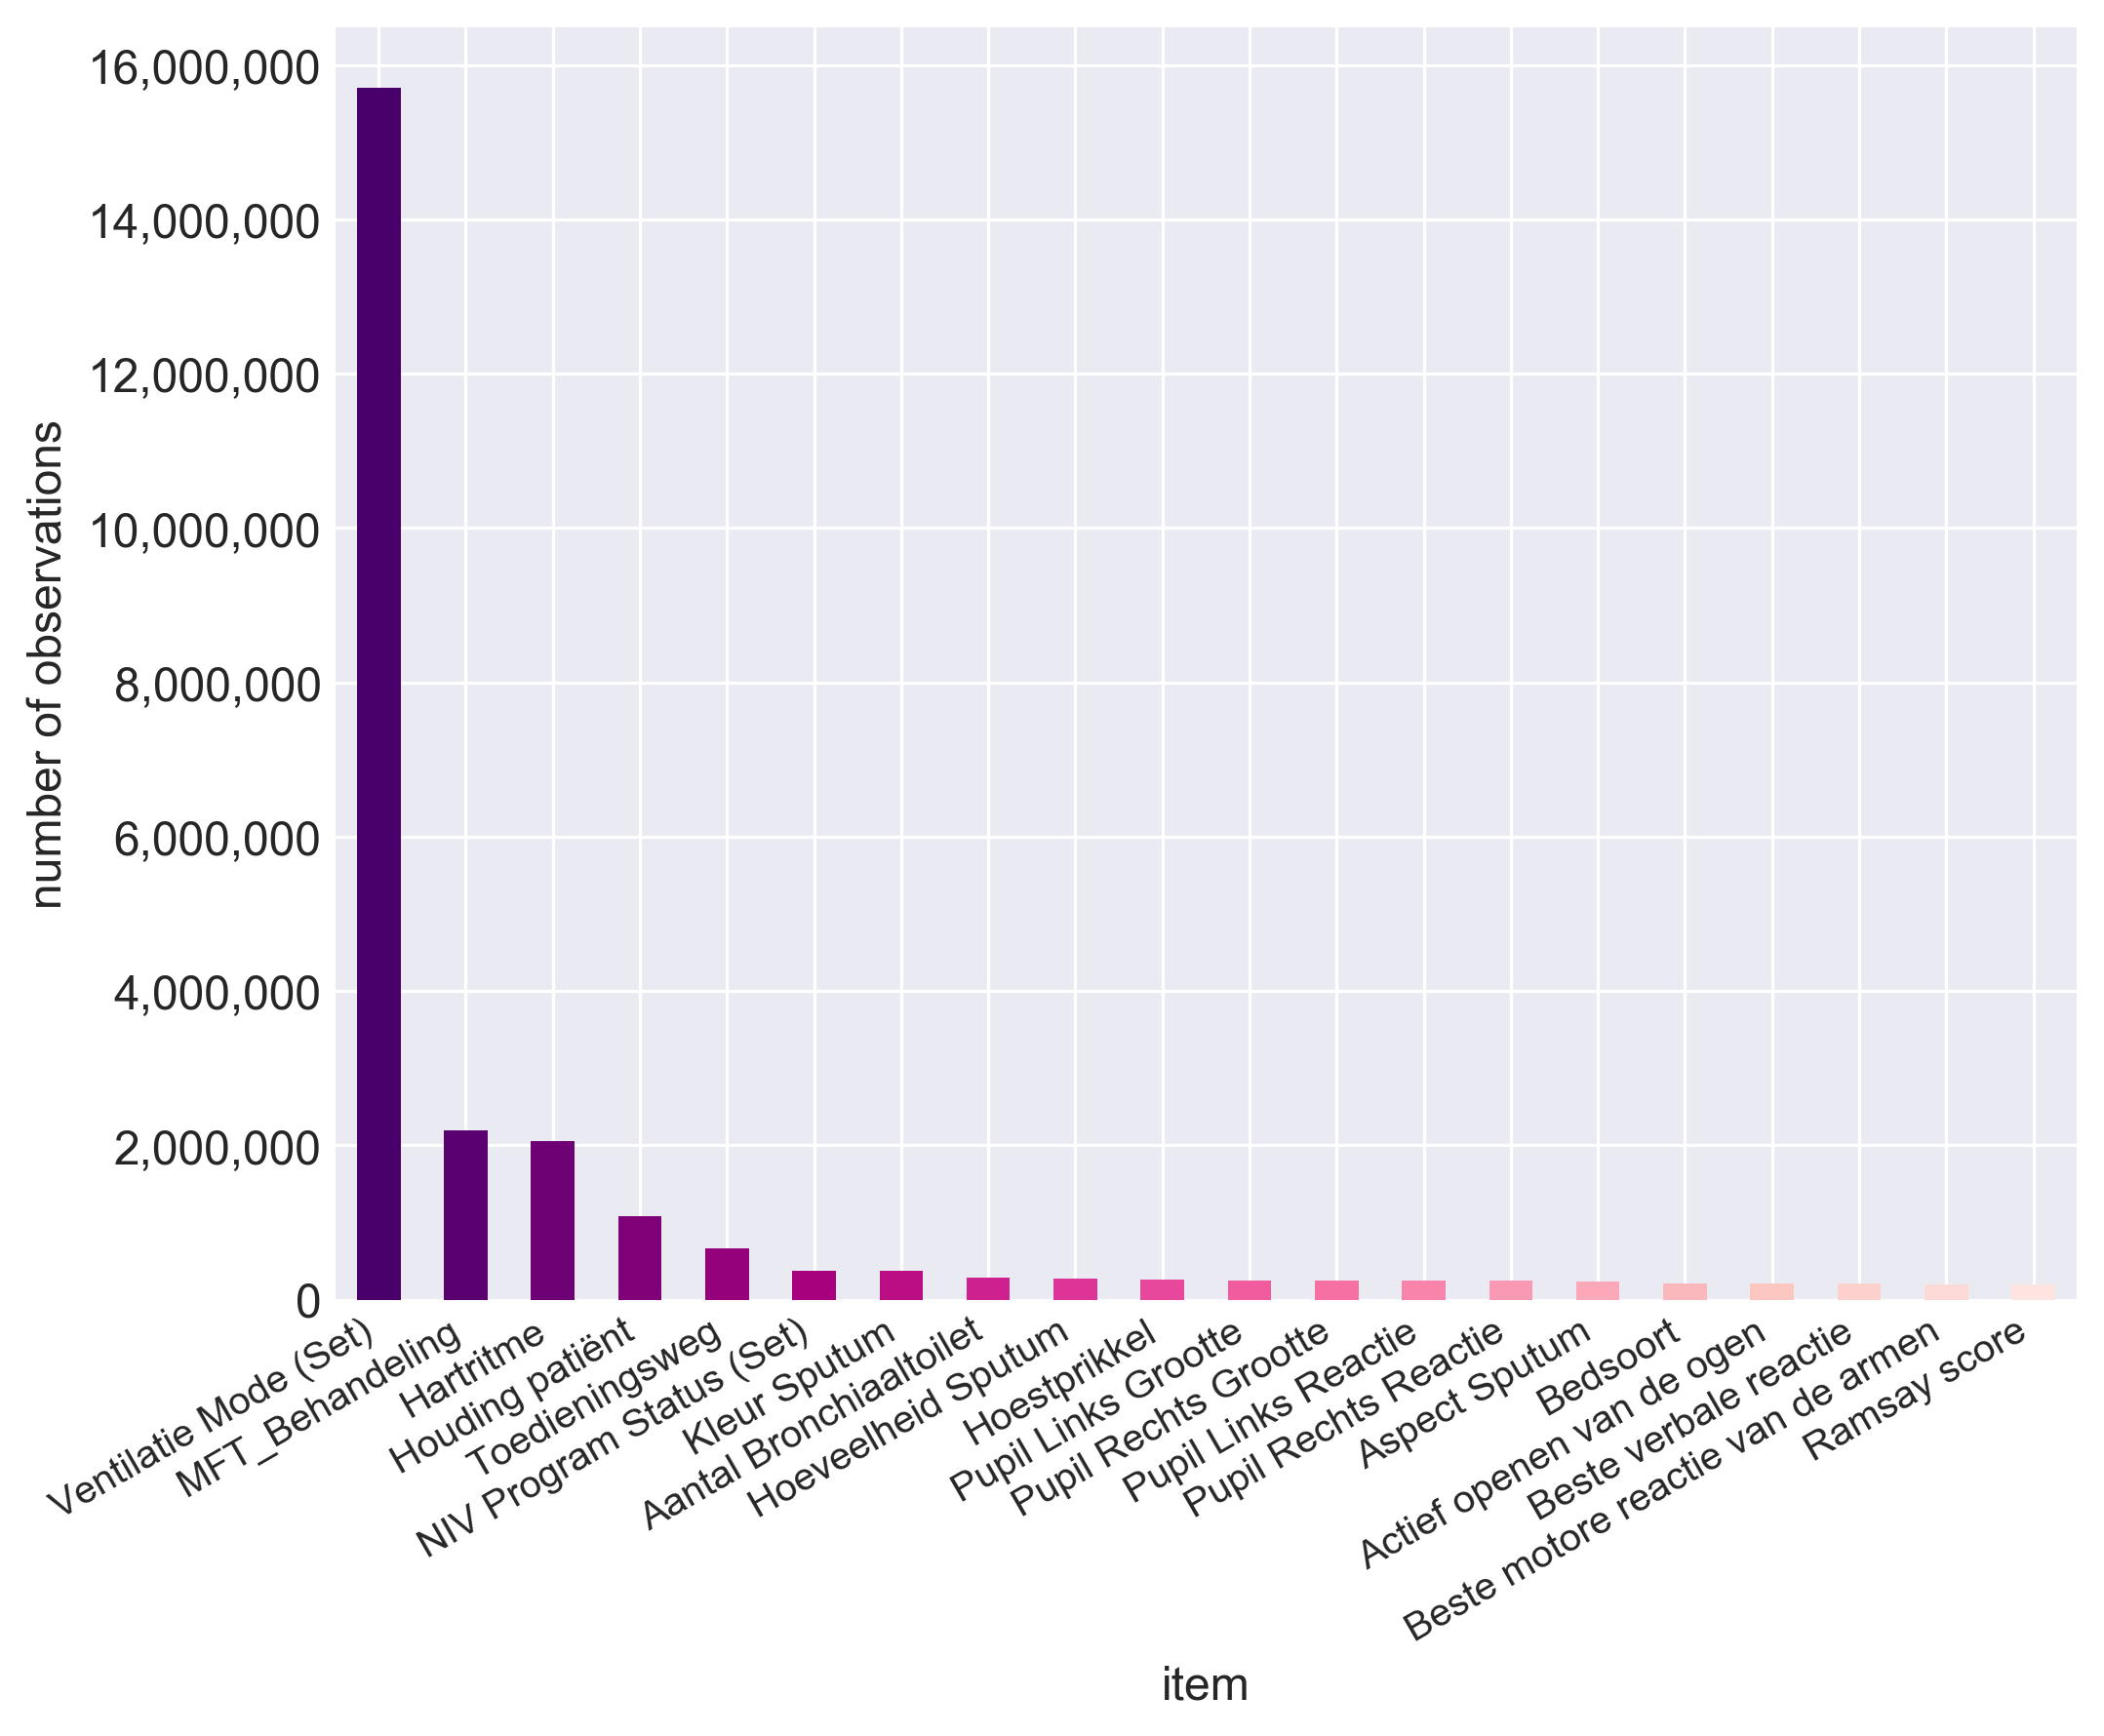

In [11]:
sql = """
SELECT item, COUNT(itemid) AS "number of observations", itemid
FROM listitems
GROUP BY item, itemid
ORDER BY "number of observations" DESC
LIMIT 20
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
cm = plt.get_cmap('RdPu')
color_step = int(-255/len(df.index))
ax = df.plot.bar(x=df.columns[0],y=df.columns[1], legend=False,color=cm(range(255,1,color_step)))
ax.set(ylabel=df.columns[1])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=30, horizontalalignment='right',fontweight='light',fontsize='small')

## <a id='value'></a>value

``` mysql

SELECT value, COUNT(itemid) AS "number of observations"
FROM listitems
WHERE itemid = 12290 --ventilation mode
GROUP BY value, item, itemid
ORDER BY "number of observations" DESC
LIMIT 5 

```

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

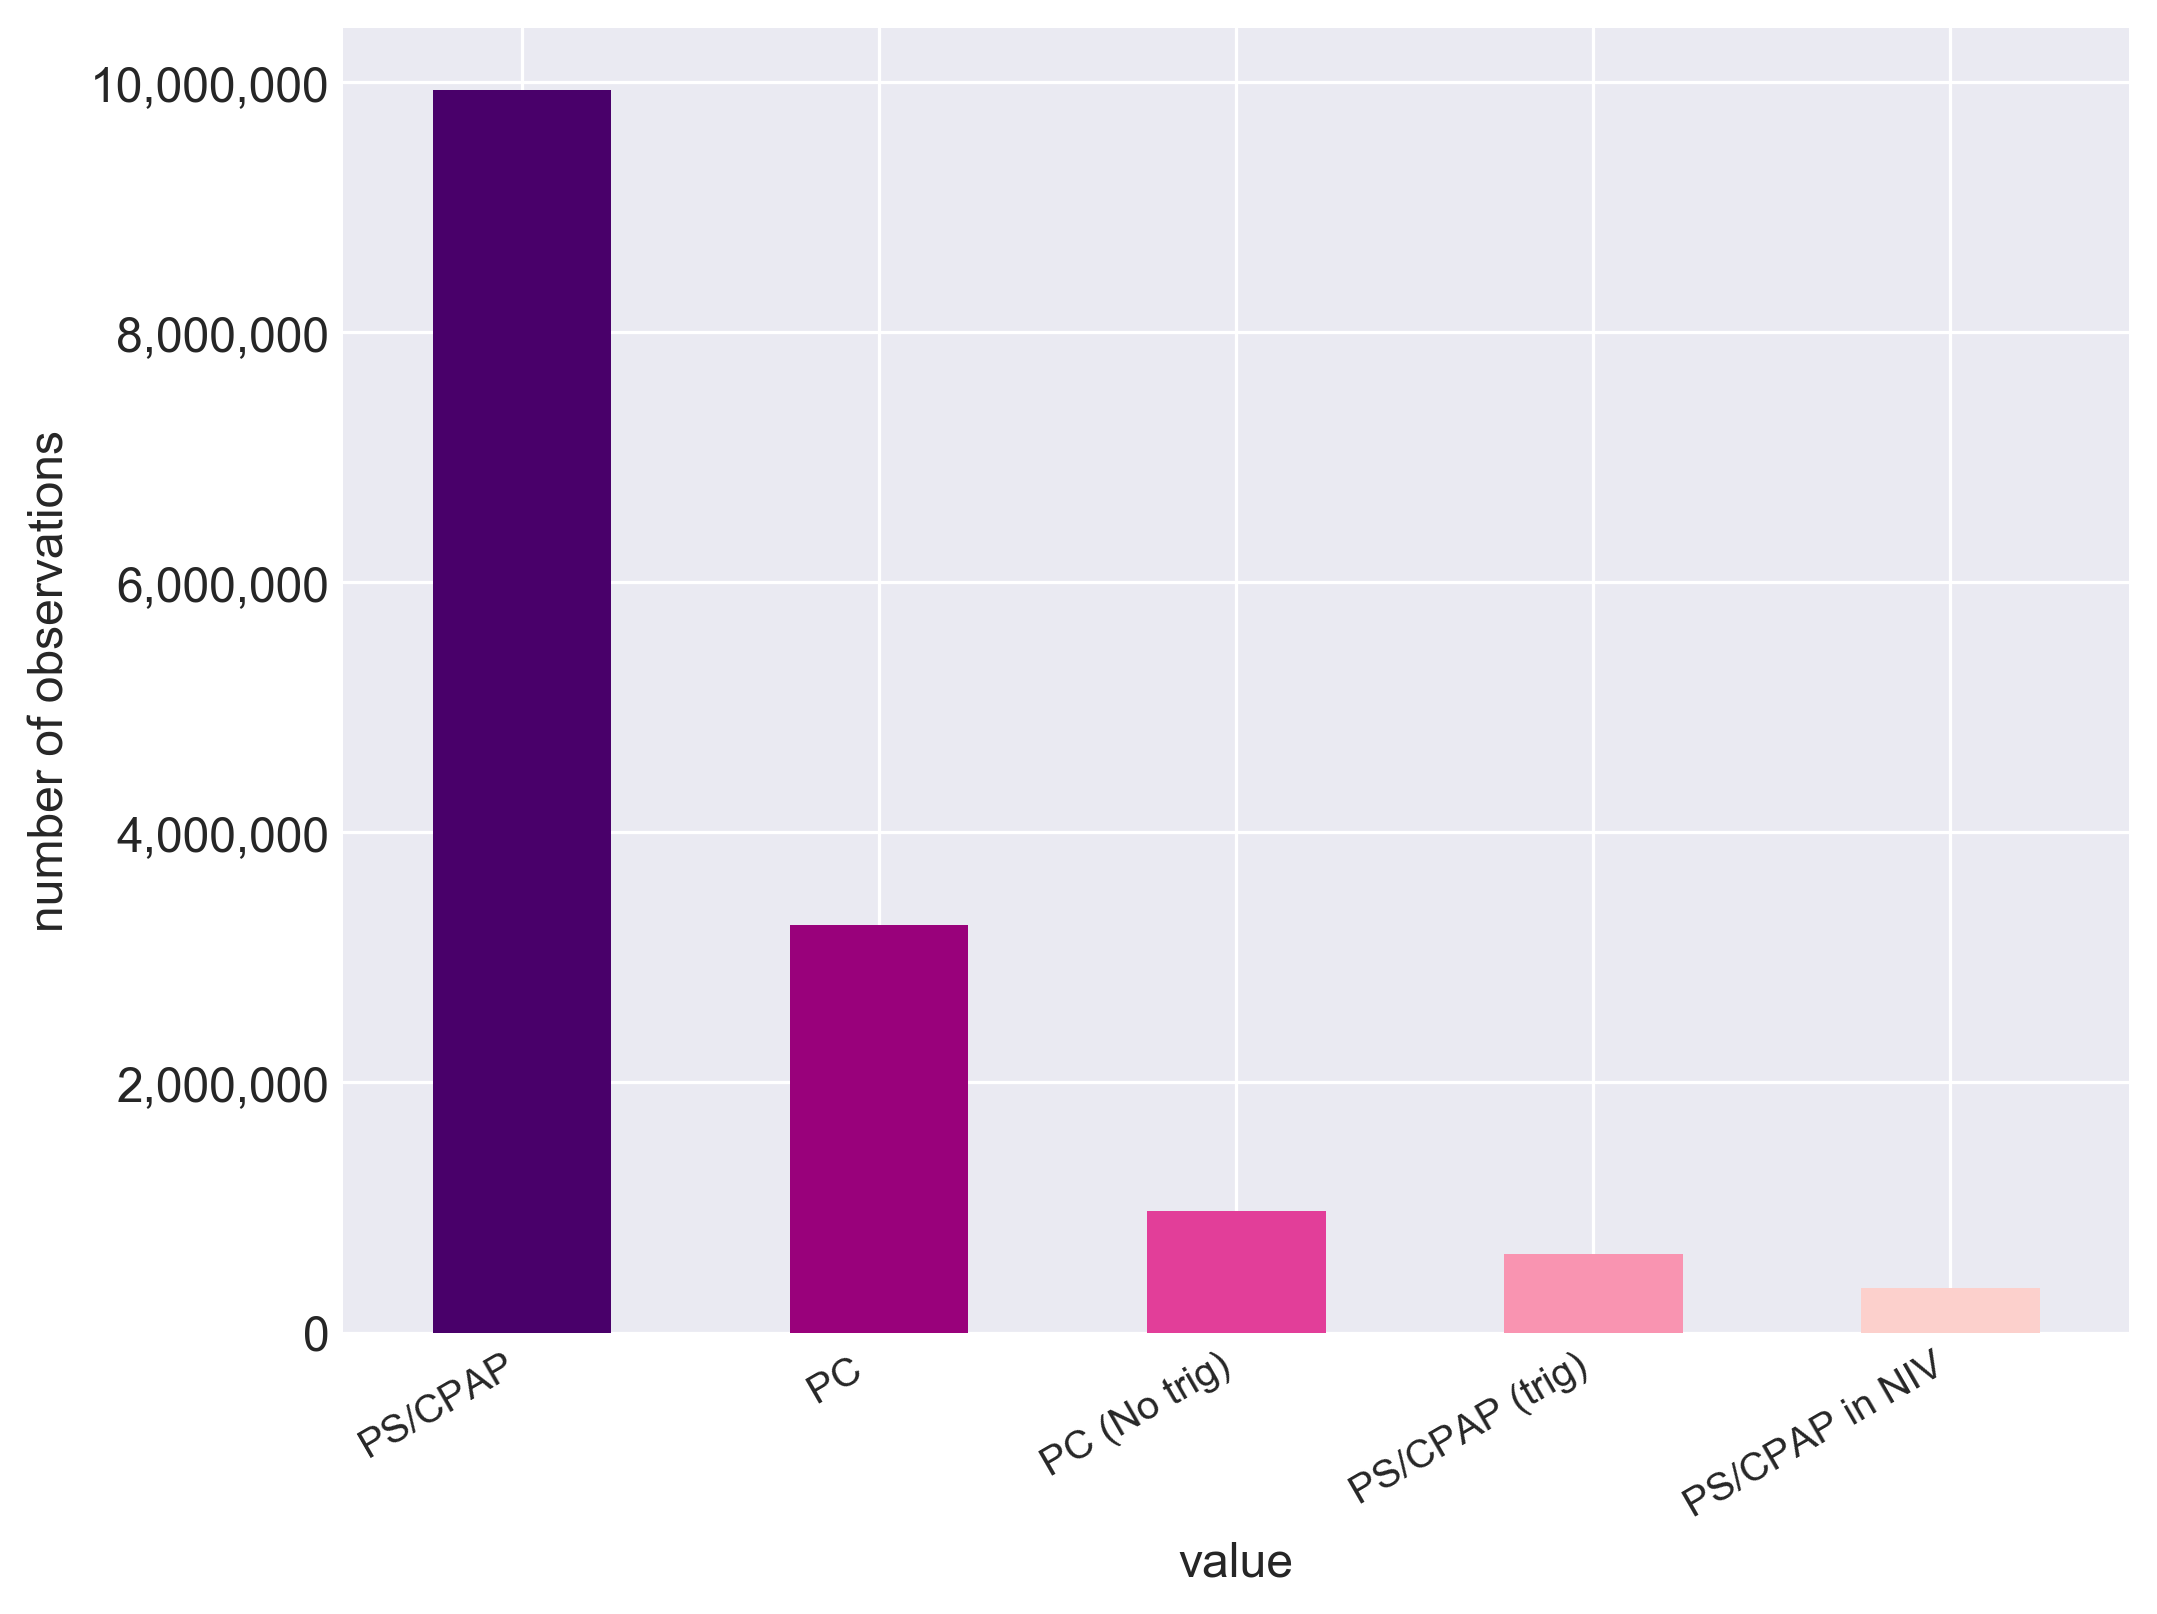

In [12]:
#shows the most often used ventilator mode: itemid = 12290 #ventilation mode
sql = """
SELECT value, COUNT(itemid) AS "number of observations"
FROM listitems
WHERE itemid = 12290 --ventilation mode
GROUP BY value, item, itemid
ORDER BY "number of observations" DESC
LIMIT 5 
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
cm = plt.get_cmap('RdPu')
color_step = int(-255/len(df.index))
ax = df.plot.bar(x=df.columns[0],y=df.columns[1], legend=False,color=cm(range(255,1,color_step)))
ax.set(ylabel=df.columns[1])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=30, horizontalalignment='right',fontweight='light',fontsize='small')

``` mysql

SELECT value, COUNT(itemid) AS "number of observations"
FROM listitems
WHERE itemid = 6671 --heart rhythm
GROUP BY value, item, itemid
ORDER BY "number of observations" DESC
LIMIT 5 

```

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

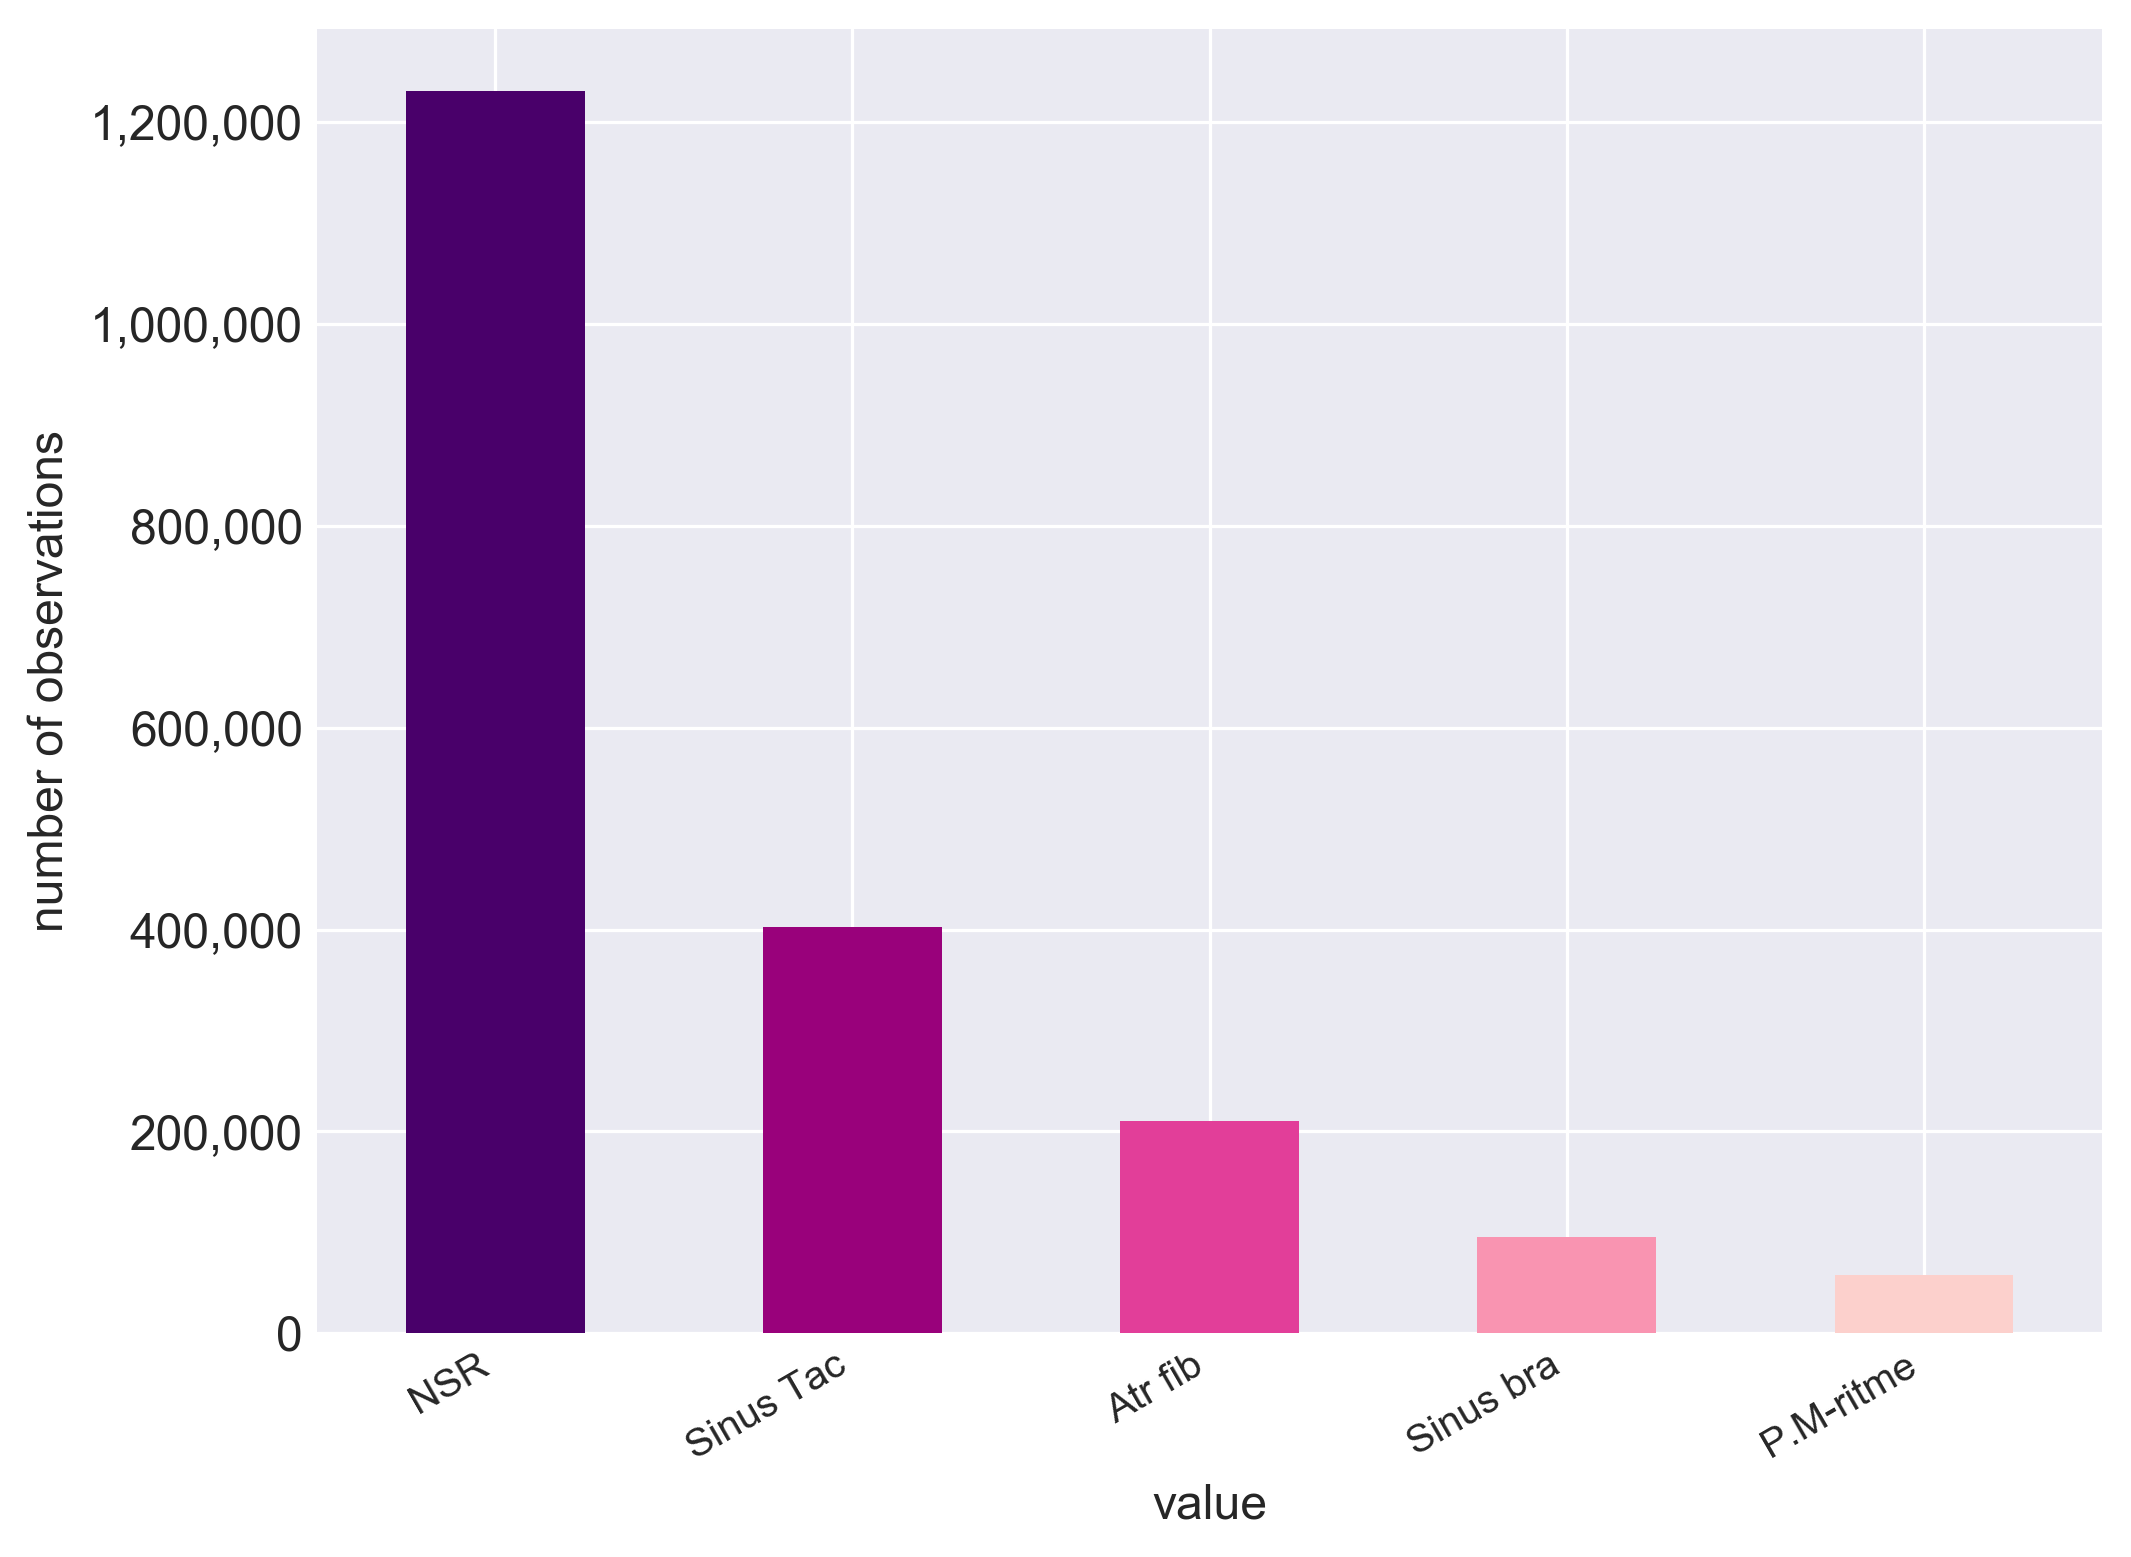

In [13]:
#shows the most often used heart rhytms mode: itemid = 6671 --heart rhythm
sql = """
SELECT value, COUNT(itemid) AS "number of observations"
FROM listitems
WHERE itemid = 6671 --heart rhythm
GROUP BY value, item, itemid
ORDER BY "number of observations" DESC
LIMIT 5 
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
cm = plt.get_cmap('RdPu')
color_step = int(-255/len(df.index))
ax = df.plot.bar(x=df.columns[0],y=df.columns[1], legend=False,color=cm(range(255,1,color_step)))
ax.set(ylabel=df.columns[1])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=30, horizontalalignment='right',fontweight='light',fontsize='small')

# <a id='apache'></a> Reason for ICU admission (based on pre-APACHE, APACHE II or IV admission diagnosis)

## Reason for admission based on pre-APACHE/APACHE II or IV diagnosis

In [14]:
sql = """
WITH diagnosis_groups AS (
SELECT admissionid,
        item, 
        value as diagnosis_group,
        CASE
            WHEN itemid = 13110 AND valueid BETWEEN 1 AND 3 THEN 1 --D_Hoofdgroep
            WHEN itemid = 16651 AND valueid BETWEEN 7 AND 9 THEN 1 --DMC_Hoofdgroep
            WHEN itemid = 16997 AND valueid BETWEEN 11 AND 20 THEN 1 --APACHE IV Groepen
            WHEN itemid = 18588 AND valueid BETWEEN 1 AND 7 THEN 1 --Apache II Hoofdgroep
            ELSE 0
        END AS surgical,
        ROW_NUMBER() OVER(PARTITION BY admissionid
        ORDER BY measuredat DESC) AS rownum
    FROM listitems
    WHERE itemid IN (
        --MAIN GROUP - LEVEL 0
        13110, --D_Hoofdgroep
        16651, --DMC_Hoofdgroep, Medium Care
        
        18588, --Apache II Hoofdgroep
        16997 --APACHE IV Groepen
        
    )
),diagnosis_subgroups AS (
SELECT admissionid,
        item, 
        value as diagnosis_subgroup,
        ROW_NUMBER() OVER(PARTITION BY admissionid
        ORDER BY measuredat DESC) AS rownum
    FROM listitems
    WHERE itemid IN (
        --SUB GROUP - LEVEL 1
        13111, --D_Subgroep_Thoraxchirurgie
        16669, --DMC_Subgroep_Thoraxchirurgie
        13112, --D_Subgroep_Algemene chirurgie
        16665, --DMC_Subgroep_Algemene chirurgie
        13113, --D_Subgroep_Neurochirurgie
        16667, --DMC_Subgroep_Neurochirurgie
        13114, --D_Subgroep_Neurologie
        16668, --DMC_Subgroep_Neurologie
        13115, --D_Subgroep_Interne geneeskunde
        16666 --DMC_Subgroep_Interne geneeskunde
    )
), diagnoses AS (
SELECT admissionid,
        item, 
        value as diagnosis,
        ROW_NUMBER() OVER(PARTITION BY admissionid
        ORDER BY measuredat DESC) AS rownum
FROM listitems
WHERE itemid IN (
        -- Diagnosis - LEVEL 2
        --SURGICAL
        13116, --D_Thoraxchirurgie_CABG en Klepchirurgie
        16671, --DMC_Thoraxchirurgie_CABG en Klepchirurgie
        13117, --D_Thoraxchirurgie_Cardio anders
        16672, --DMC_Thoraxchirurgie_Cardio anders
        13118, --D_Thoraxchirurgie_Aorta chirurgie
        16670, --DMC_Thoraxchirurgie_Aorta chirurgie
        13119, --D_Thoraxchirurgie_Pulmonale chirurgie
        16673, --DMC_Thoraxchirurgie_Pulmonale chirurgie
        
        
        13141, --D_Algemene chirurgie_Algemeen   
        16642, --DMC_Algemene chirurgie_Algemeen
        13121, --D_Algemene chirurgie_Buikchirurgie
        16643, --DMC_Algemene chirurgie_Buikchirurgie
        13123, --D_Algemene chirurgie_Endocrinologische chirurgie
        16644, --DMC_Algemene chirurgie_Endocrinologische chirurgie
        13145, --D_Algemene chirurgie_KNO/Overige
        16645, --DMC_Algemene chirurgie_KNO/Overige
        13125, --D_Algemene chirurgie_Orthopedische chirurgie
        16646, --DMC_Algemene chirurgie_Orthopedische chirurgie
        13122, --D_Algemene chirurgie_Transplantatie chirurgie
        16647, --DMC_Algemene chirurgie_Transplantatie chirurgie
        13124, --D_Algemene chirurgie_Trauma
        16648, --DMC_Algemene chirurgie_Trauma
        13126, --D_Algemene chirurgie_Urogenitaal
        16649, --DMC_Algemene chirurgie_Urogenitaal
        13120, --D_Algemene chirurgie_Vaatchirurgie
        16650, --DMC_Algemene chirurgie_Vaatchirurgie

        13128, --D_Neurochirurgie _Vasculair chirurgisch
        16661, --DMC_Neurochirurgie _Vasculair chirurgisch
        13129, --D_Neurochirurgie _Tumor chirurgie
        16660, --DMC_Neurochirurgie _Tumor chirurgie
        13130, --D_Neurochirurgie_Overige
        16662, --DMC_Neurochirurgie_Overige
        
        18596, --Apache II Operatief  Gastr-intenstinaal
        18597, --Apache II Operatief Cardiovasculair
        18598, --Apache II Operatief Hematologisch
        18599, --Apache II Operatief Metabolisme
        18600, --Apache II Operatief Neurologisch
        18601, --Apache II Operatief Renaal
        18602, --Apache II Operatief Respiratoir
        
        17008, --APACHEIV Post-operative cardiovascular
        17009, --APACHEIV Post-operative gastro-intestinal
        17010, --APACHEIV Post-operative genitourinary
        17011, --APACHEIV Post-operative hematology
        17012, --APACHEIV Post-operative metabolic
        17013, --APACHEIV Post-operative musculoskeletal /skin
        17014, --APACHEIV Post-operative neurologic
        17015, --APACHEIV Post-operative respiratory
        17016, --APACHEIV Post-operative transplant
        17017, --APACHEIV Post-operative trauma

        --MEDICAL
        13133, --D_Interne Geneeskunde_Cardiovasculair
        16653, --DMC_Interne Geneeskunde_Cardiovasculair
        13134, --D_Interne Geneeskunde_Pulmonaal
        16658, --DMC_Interne Geneeskunde_Pulmonaal
        13135, --D_Interne Geneeskunde_Abdominaal
        16652, --DMC_Interne Geneeskunde_Abdominaal
        13136, --D_Interne Geneeskunde_Infectieziekten
        16655, --DMC_Interne Geneeskunde_Infectieziekten
        13137, --D_Interne Geneeskunde_Metabool
        16656, --DMC_Interne Geneeskunde_Metabool
        13138, --D_Interne Geneeskunde_Renaal
        16659, --DMC_Interne Geneeskunde_Renaal
        13139, --D_Interne Geneeskunde_Hematologisch
        16654, --DMC_Interne Geneeskunde_Hematologisch
        13140, --D_Interne Geneeskunde_Overige
        16657, --DMC_Interne Geneeskunde_Overige

        13131, --D_Neurologie_Vasculair neurologisch
        16664, --DMC_Neurologie_Vasculair neurologisch
        13132, --D_Neurologie_Overige
        16663, --DMC_Neurologie_Overige 
        13127, --D_KNO/Overige
        
        18589, --Apache II Non-Operatief Cardiovasculair
        18590, --Apache II Non-Operatief Gastro-intestinaal
        18591, --Apache II Non-Operatief Hematologisch
        18592, --Apache II Non-Operatief Metabolisme
        18593, --Apache II Non-Operatief Neurologisch
        18594, --Apache II Non-Operatief Renaal
        18595, --Apache II Non-Operatief Respiratoir
        
        16998, --APACHE IV Non-operative cardiovascular
        16999, --APACHE IV Non-operative Gastro-intestinal
        17000, --APACHE IV Non-operative genitourinary
        17001, --APACHEIV  Non-operative haematological
        17002, --APACHEIV  Non-operative metabolic
        17003, --APACHEIV Non-operative musculo-skeletal
        17004, --APACHEIV Non-operative neurologic
        17005, --APACHEIV Non-operative respiratory
        17006, --APACHEIV Non-operative transplant
        17007 --APACHEIV Non-operative trauma      
        
        )
)
SELECT admissions.admissionid, admissionyeargroup AS "admission year", diagnosis, diagnosis_subgroup, 
    diagnosis_group, surgical
FROM admissions
LEFT JOIN diagnoses on admissions.admissionid = diagnoses.admissionid
LEFT JOIN diagnosis_subgroups on admissions.admissionid = diagnosis_subgroups.admissionid
LEFT JOIN diagnosis_groups on admissions.admissionid = diagnosis_groups.admissionid
WHERE (diagnoses.rownum = 1 OR diagnoses.rownum IS NULL) AND 
    (diagnosis_subgroups.rownum = 1 OR diagnosis_subgroups.rownum IS NULL) AND
    (diagnosis_groups.rownum = 1 OR diagnosis_groups.rownum IS NULL) --only last updated record
;
"""
combined_diagnoses = pd.read_sql(sql,con)
combined_diagnoses.head()

,admissionid,admission year,diagnosis,diagnosis_subgroup,diagnosis_group,surgical
0,0,2003-2009,CABG,CABG en Klepchirurgie,Thoraxchirurgie,1.0
1,1,2010-2016,Bentall,Aorta chirurgie,Thoraxchirurgie,1.0
2,2,2010-2016,CABG with aortic valve replacement,CABG en Klepchirurgie,Post-operative cardiovascular,1.0
3,3,2003-2009,None,None,None,NaN
4,4,2010-2016,"CABG alone, coronary artery bypass grafting",CABG en Klepchirurgie,Post-operative cardiovascular,1.0


In [15]:
plotdata = combined_diagnoses[['surgical']].copy()
plotdata.loc[plotdata['surgical'] == 1, 'group'] = 'Surgical'
plotdata.loc[plotdata['surgical'] == 0, 'group'] = 'Medical'
plotdata.loc[plotdata['surgical'].isna(), 'group'] = '*N/A*'
plotdata = plotdata.groupby('group').size().to_frame('Number of admissions').reset_index()
plotdata

,group,Number of admissions
0,*N/A*,6051
1,Medical,5603
2,Surgical,11518


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

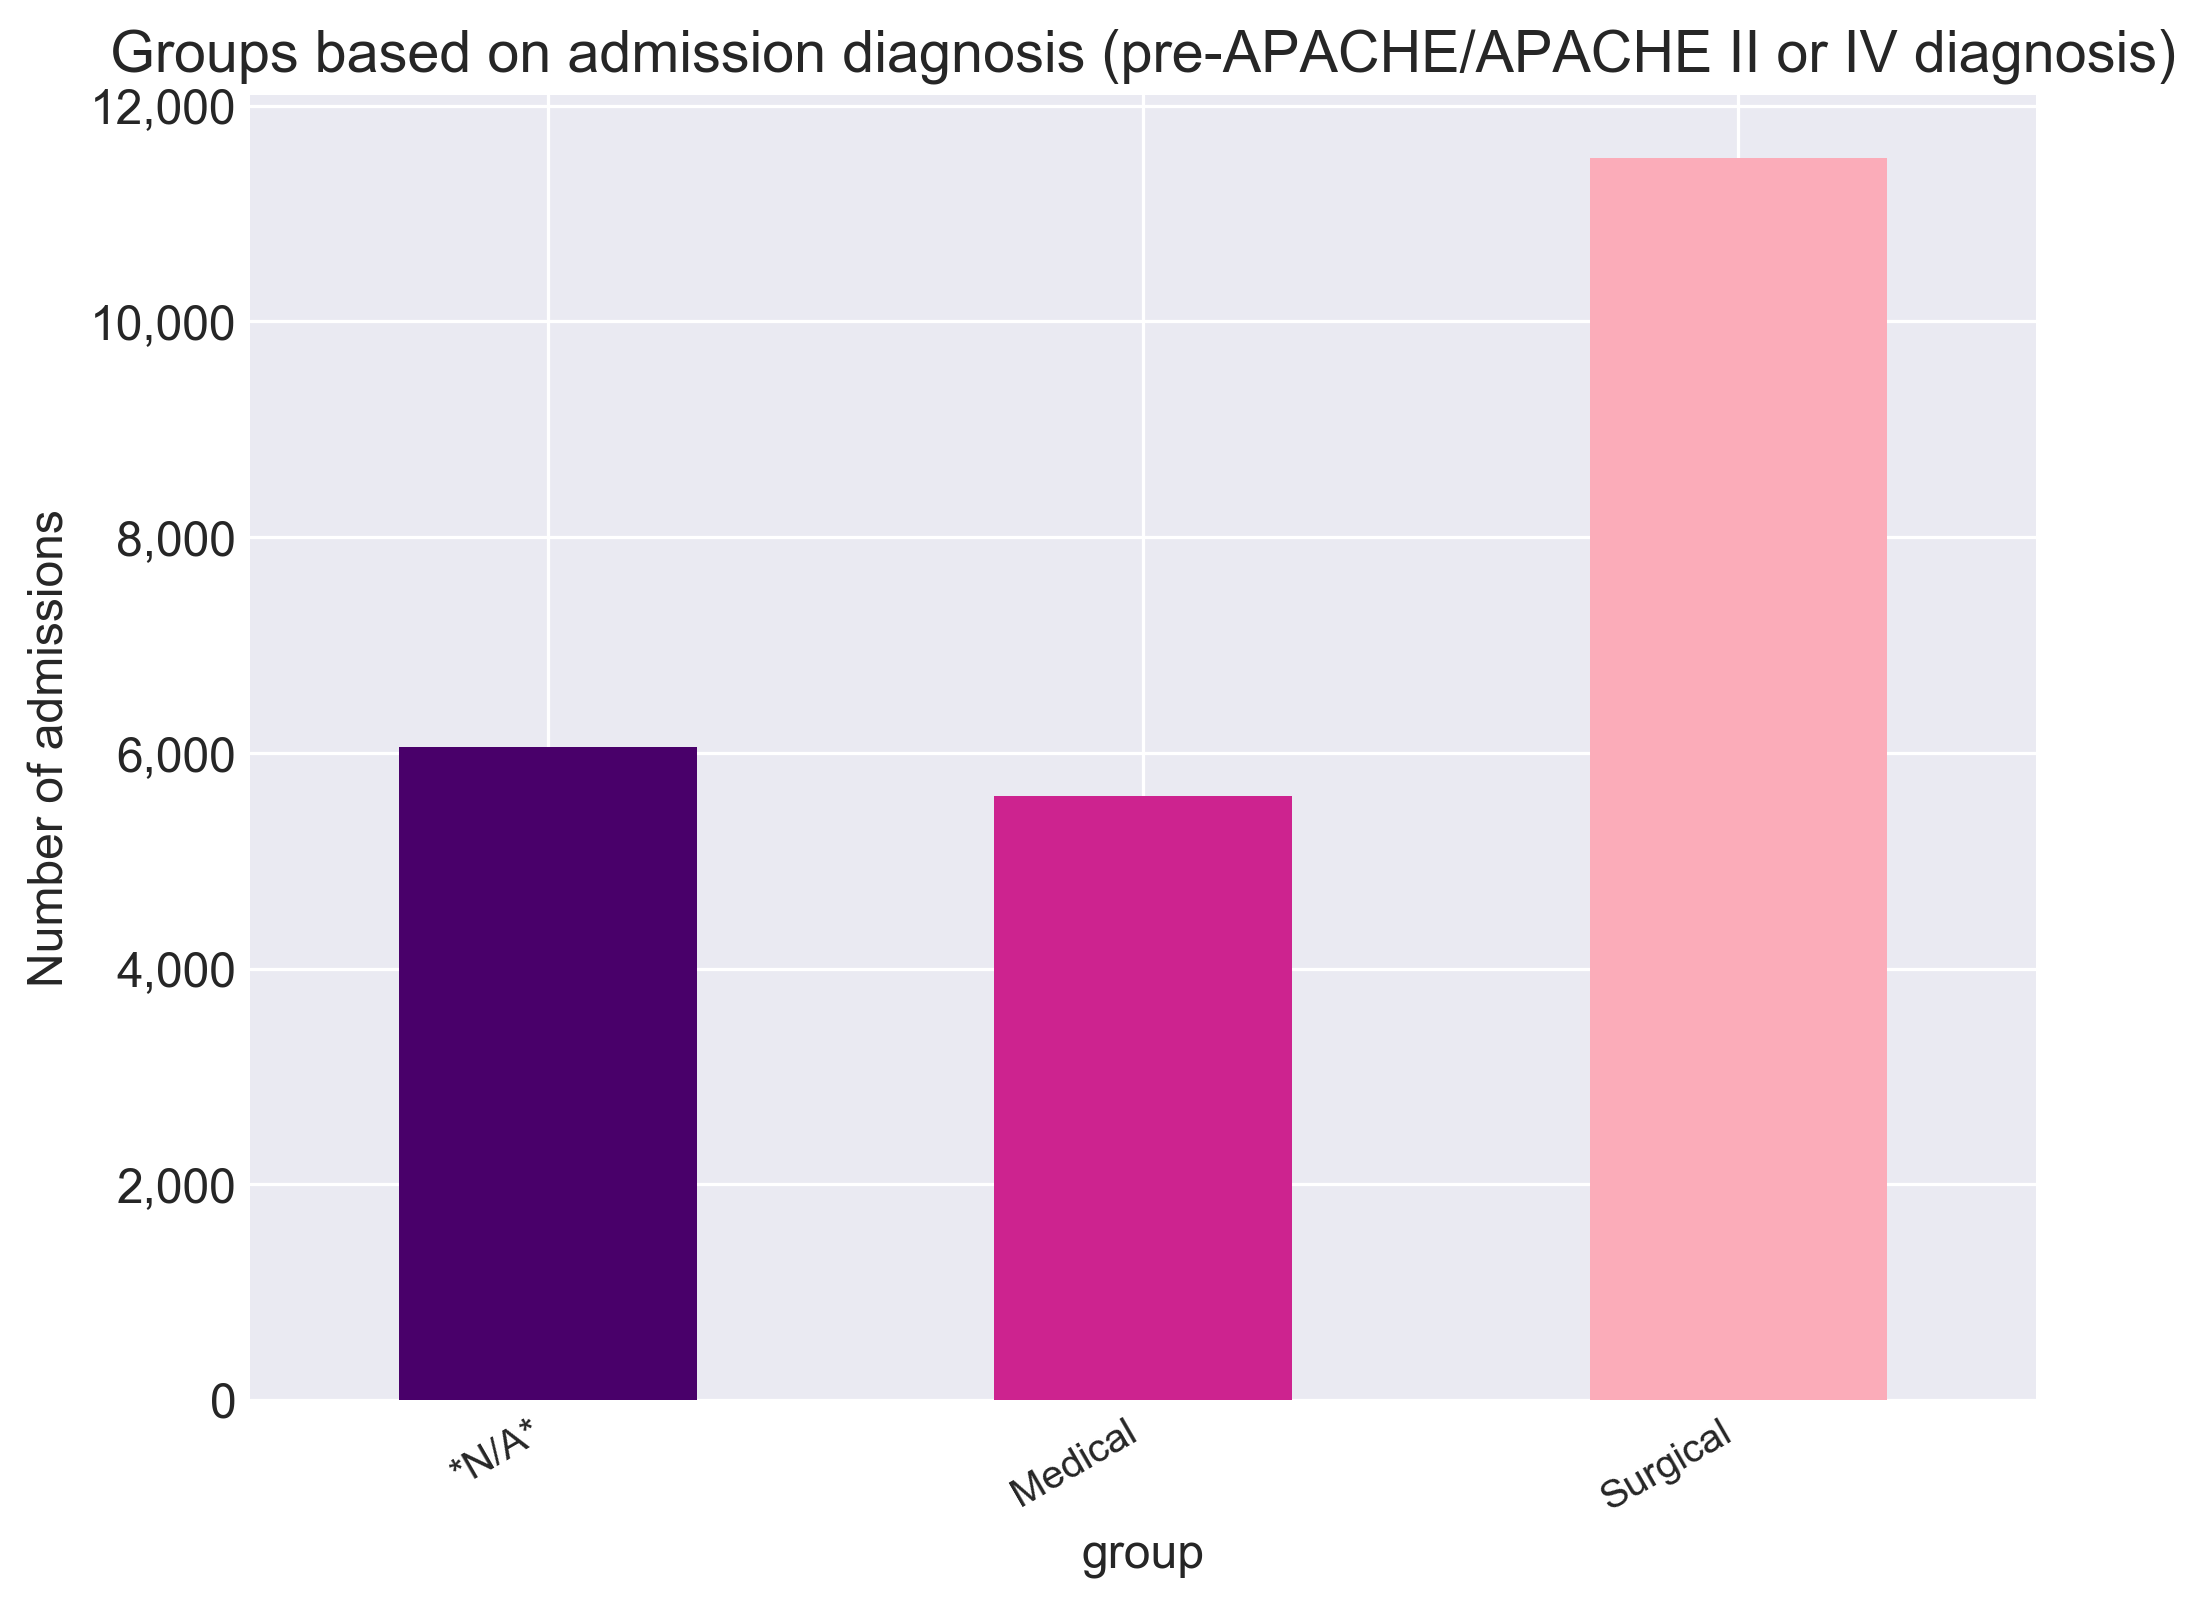

In [16]:
#plot the data
cm = plt.get_cmap('RdPu')
color_step = int(-255/len(plotdata))
ax = plotdata.plot.bar(x=plotdata.columns[0],y=plotdata.columns[1], legend=False,color=cm(range(255,1,color_step)))
ax.set(title='Groups based on admission diagnosis (pre-APACHE/APACHE II or IV diagnosis)', ylabel=plotdata.columns[1])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=30, horizontalalignment='right',fontweight='light',fontsize='small')

In [17]:
plotdata = combined_diagnoses[['diagnosis_group']].copy()
plotdata = plotdata.groupby('diagnosis_group').size().to_frame('number of admissions').sort_values(by='number of admissions', ascending=False).reset_index()
plotdata

,diagnosis_group,number of admissions
0,Thoraxchirurgie,3545
1,Interne geneeskunde,2438
2,Algemene chirurgie,2234
3,Post-operative cardiovascular,1526
4,Operatief Cardiovasculair,1256
...,...,...
33,Post-operative metabolic,13
34,Operatief Metabolisme,8
35,Operatief Hematologisch,5
36,Non-operative musculo-skeletal,3


In [18]:
sql = """
WITH diagnoses AS (
    SELECT admissionid,
            item, 
            value AS main_group,
            ROW_NUMBER() OVER(PARTITION BY admissionid
            ORDER BY measuredat DESC) AS rownum
    FROM listitems
    WHERE itemid IN (
        --MAIN GROUP - LEVEL 0
        13110, --D_Hoofdgroep
        16651, --DMC_Hoofdgroep, Medium Care
        
        18588, --Apache II Hoofdgroep
        16997 --APACHE IV Groepen
    )
)
SELECT admissionyeargroup AS "admission year", Count(*) AS "number of patients", 
    Count(main_group) AS "available diagnosis group", Count(*) - Count(main_group) AS "*N/A*"
FROM admissions
LEFT JOIN diagnoses on admissions.admissionid = diagnoses.admissionid
WHERE rownum = 1 OR rownum IS NULL --only last updated record
GROUP BY ROLLUP(admissionyeargroup)
ORDER BY admissionyeargroup;
"""
admissiondiagnosis = pd.read_sql(sql,con)
admissiondiagnosis

,admission year,number of patients,available diagnosis group,*N/A*
0,2003-2009,9936,4459,5477
1,2010-2016,13236,12662,574
2,None,23172,17121,6051


(array([0, 1]), <a list of 2 Text xticklabel objects>)

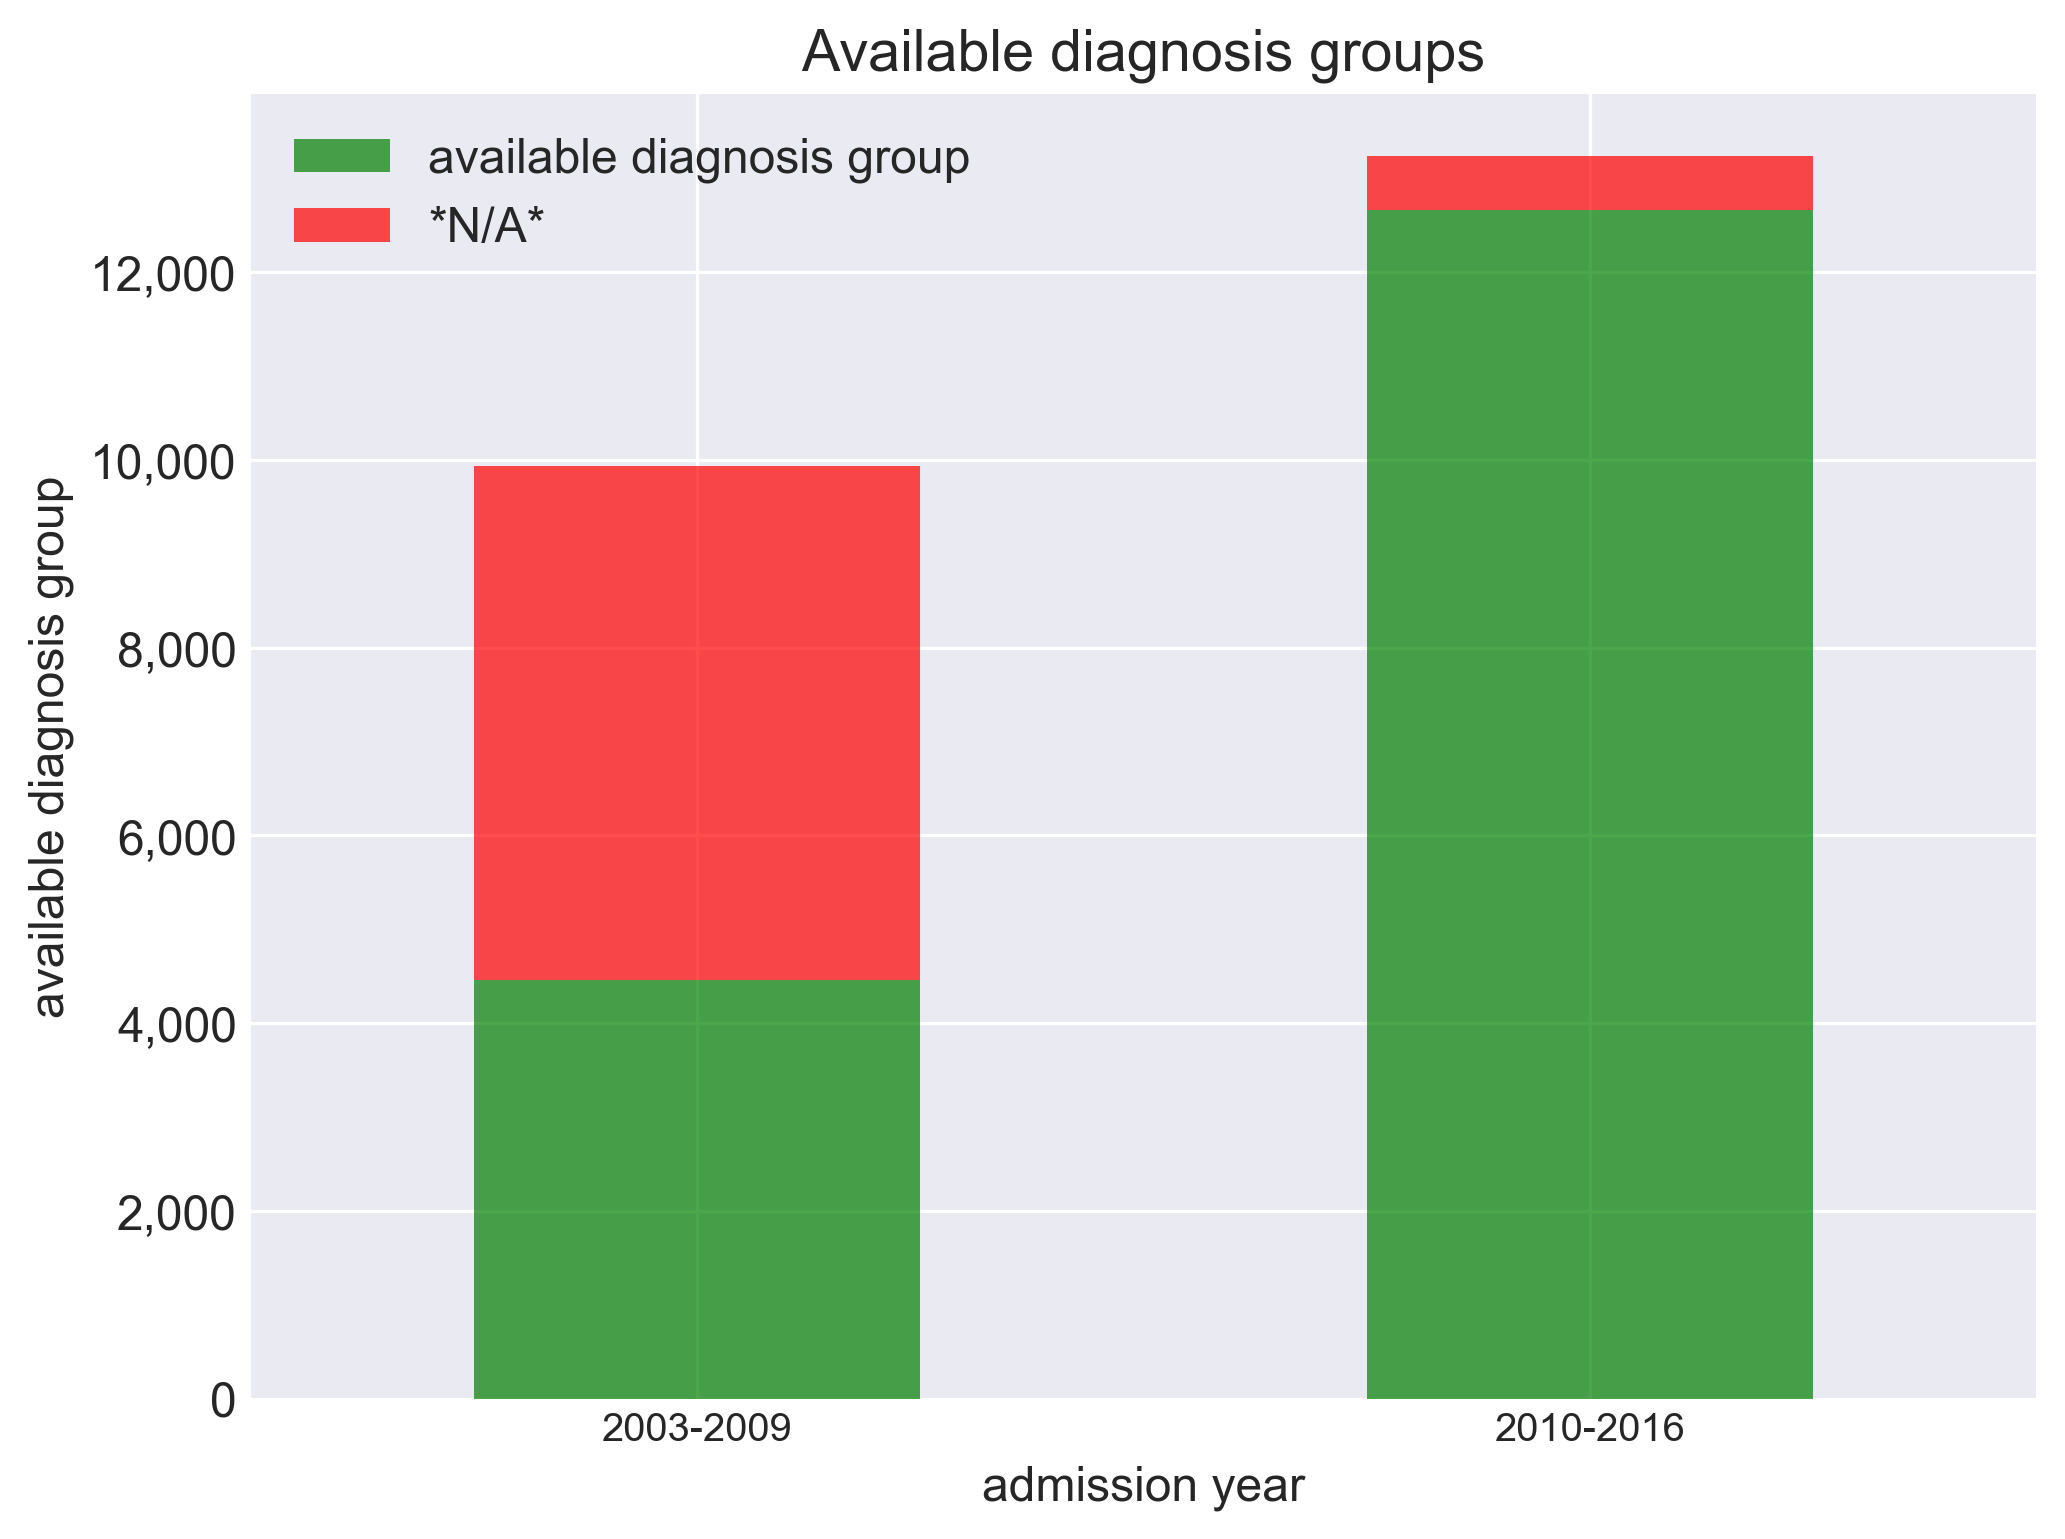

In [19]:
#plot the data
plotdata  = admissiondiagnosis[['admission year','available diagnosis group', '*N/A*']].iloc[0:-1]
cm = plt.get_cmap('RdPu')
color_step = int(-255/len(plotdata.index))
ax = plotdata.plot.bar(x=plotdata.columns[0],y=plotdata.columns[[1,2]], stacked=True, legend=True,color=['g','r'], alpha=0.70)
ax.set(title='Available diagnosis groups', xlabel=plotdata.columns[0], ylabel=plotdata.columns[1])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=0, horizontalalignment='center',fontweight='light',fontsize='small')

## Pre-APACHE diagnosis groups

In [20]:
sql = """
WITH diagnoses AS (
    SELECT admissionid,
            item, 
            value AS main_group,
            ROW_NUMBER() OVER(PARTITION BY admissionid
            ORDER BY measuredat DESC) AS rownum
    FROM listitems
    WHERE itemid IN (
        13110, --D_Hoofdgroep
        16651 --DMC_Hoofdgroep
    )
)
SELECT admissionyeargroup AS "admission year", Count(admissions.admissionid) AS "number of admissions", 
    Count(main_group) AS "Available Pre-APACHE diagnosis group", Count(admissions.admissionid) - Count(main_group) AS "*N/A*"
FROM admissions
LEFT JOIN diagnoses on admissions.admissionid = diagnoses.admissionid
WHERE rownum = 1 OR rownum IS NULL --only last updated record
GROUP BY ROLLUP(admissionyeargroup) --calculates a totals row
ORDER BY admissionyeargroup;
"""
admissiondiagnosis = pd.read_sql(sql,con)
admissiondiagnosis

,admission year,number of admissions,Available Pre-APACHE diagnosis group,*N/A*
0,2003-2009,9936,4457,5479
1,2010-2016,13236,12661,575
2,None,23172,17118,6054


(array([0, 1]), <a list of 2 Text xticklabel objects>)

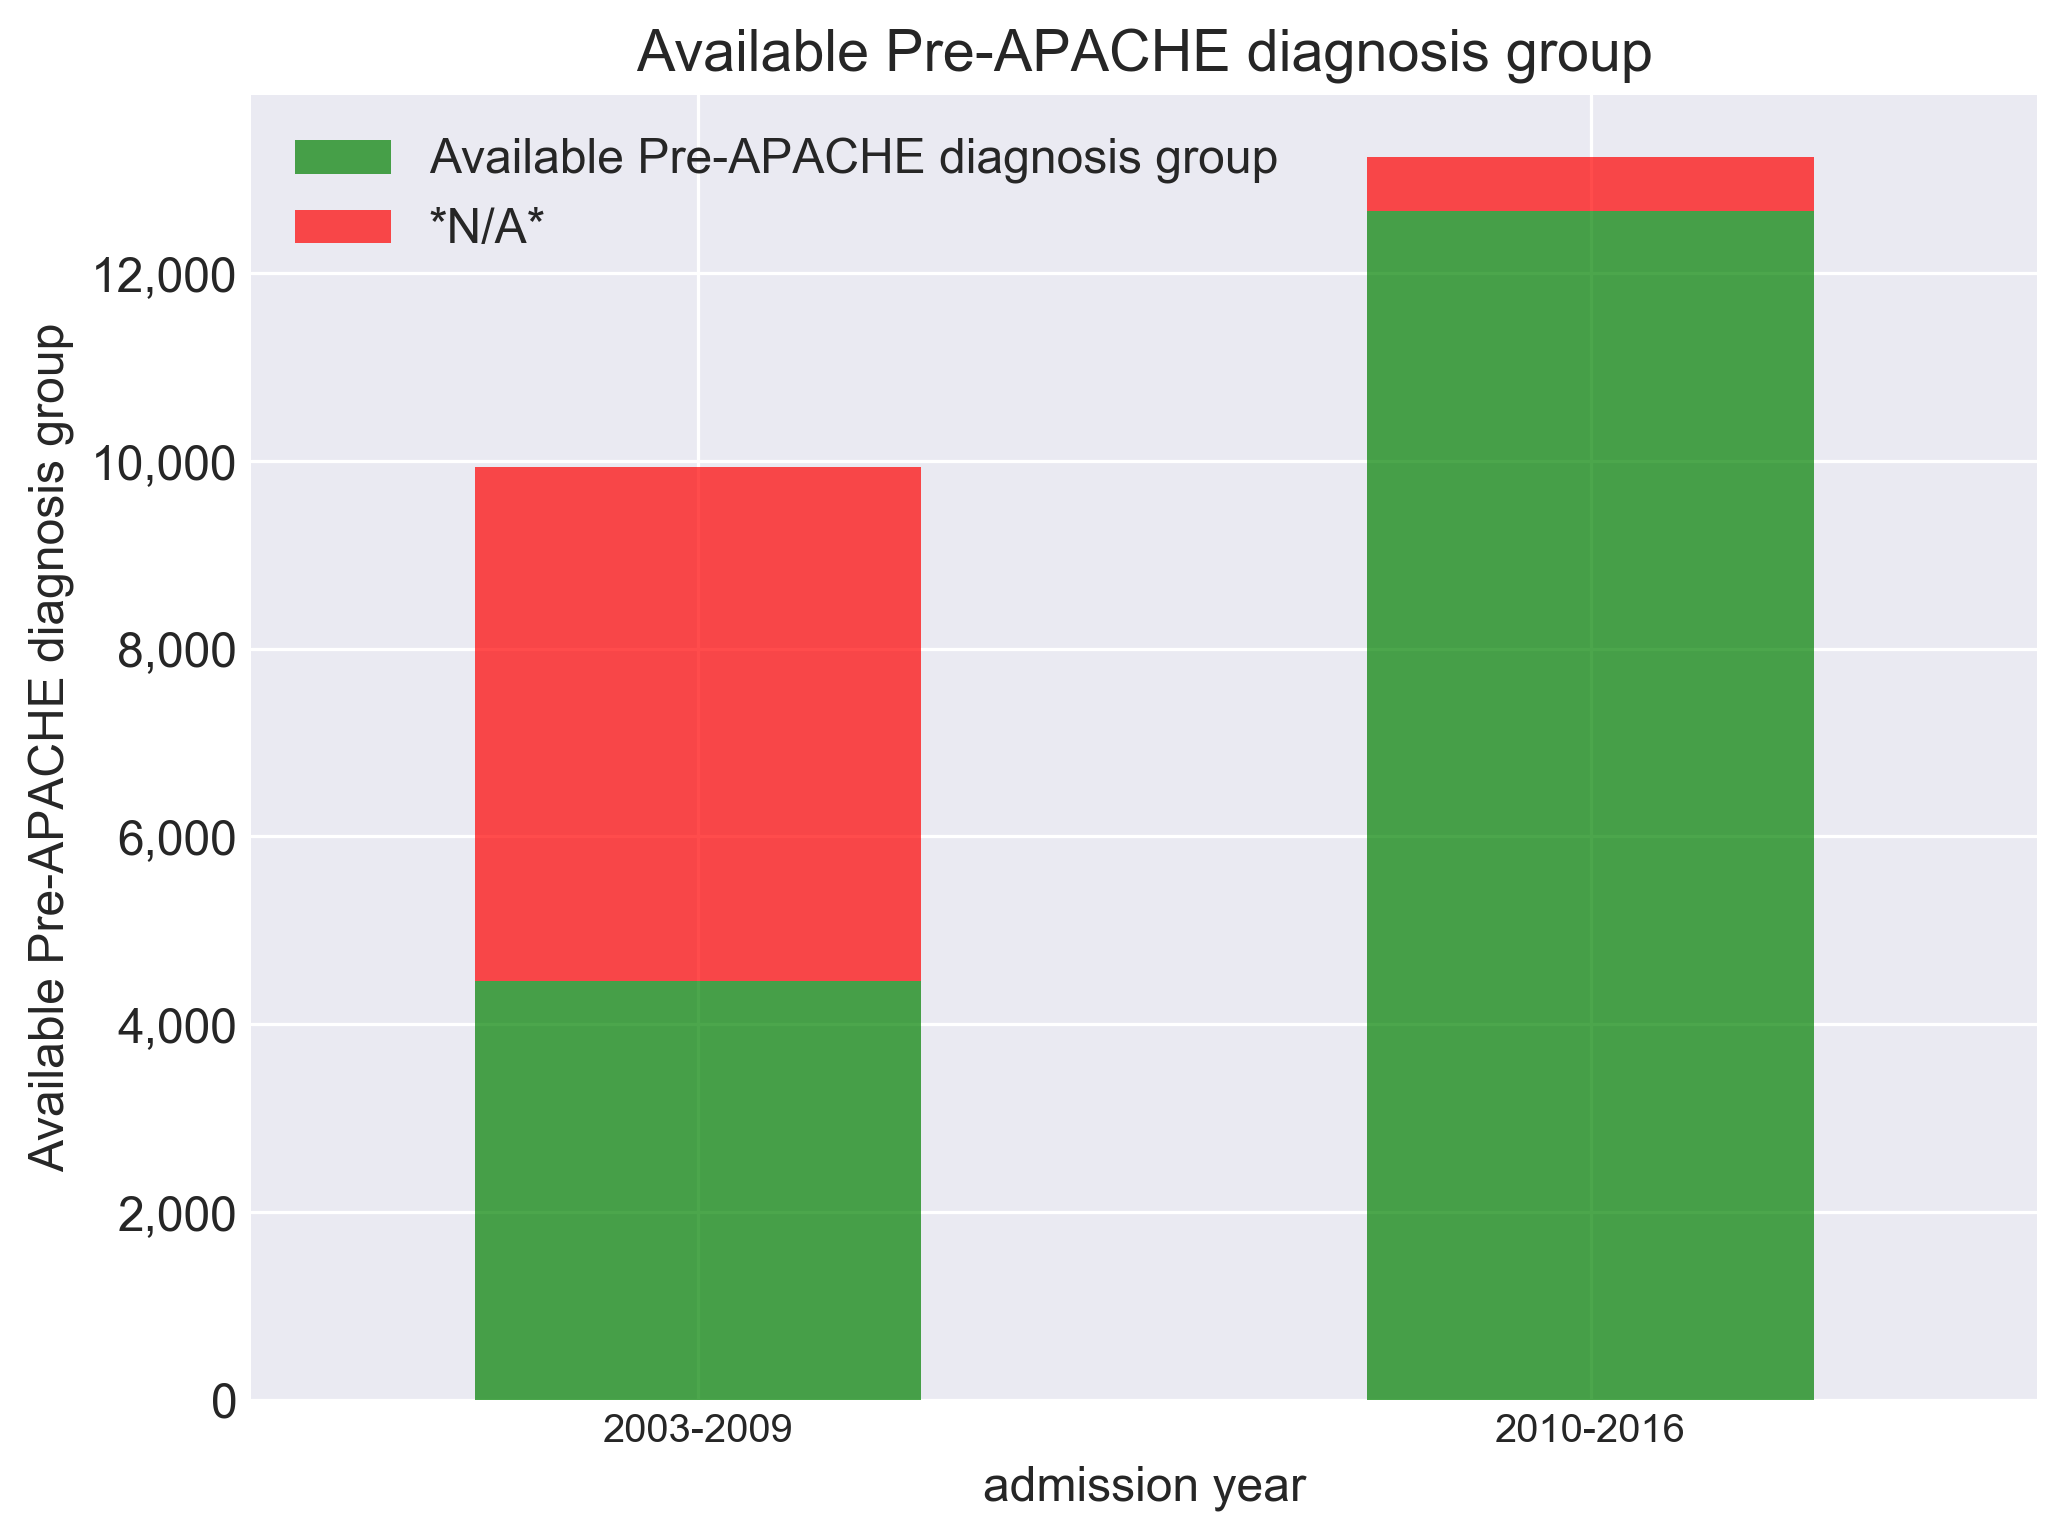

In [21]:
#plot the data
plotdata  = admissiondiagnosis[['admission year','Available Pre-APACHE diagnosis group', '*N/A*']].iloc[0:-1]
ax = plotdata.plot.bar(x=plotdata.columns[0],y=plotdata.columns[[1,2]], stacked=True, legend=True,color=['g','r'], alpha=0.70)
ax.set(title='Available Pre-APACHE diagnosis group', xlabel=plotdata.columns[0], ylabel=plotdata.columns[1])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=0, horizontalalignment='center',fontweight='light',fontsize='small')

### Pre-APACHE diagnosis group levels: main group, subgroup, ICU admission diagnosis

In [22]:
sql = """
WITH diagnosis_groups AS (
SELECT admissionid,
        item, 
        value as diagnosis_group,
        ROW_NUMBER() OVER(PARTITION BY admissionid
        ORDER BY measuredat DESC) AS rownum
    FROM listitems
    WHERE itemid IN (
        --MAIN GROUP - LEVEL 0
        13110, --D_Hoofdgroep
        16651 --DMC_Hoofdgroep, Medium Care
    )
),diagnosis_subgroups AS (
SELECT admissionid,
        item, 
        value as diagnosis_subgroup,
        ROW_NUMBER() OVER(PARTITION BY admissionid
        ORDER BY measuredat DESC) AS rownum
    FROM listitems
    WHERE itemid IN (
        --SUB GROUP - LEVEL 1
        13111, --D_Subgroep_Thoraxchirurgie
        16669, --DMC_Subgroep_Thoraxchirurgie
        13112, --D_Subgroep_Algemene chirurgie
        16665, --DMC_Subgroep_Algemene chirurgie
        13113, --D_Subgroep_Neurochirurgie
        16667, --DMC_Subgroep_Neurochirurgie
        13114, --D_Subgroep_Neurologie
        16668, --DMC_Subgroep_Neurologie
        13115, --D_Subgroep_Interne geneeskunde
        16666 --DMC_Subgroep_Interne geneeskunde
    )
), diagnoses AS (
SELECT admissionid,
        item, 
        value as diagnosis,
        CASE 
            WHEN item ILIKE '%chirurgie%' THEN 1
            ELSE 0
        END AS surgical,
        ROW_NUMBER() OVER(PARTITION BY admissionid
        ORDER BY measuredat DESC) AS rownum
FROM listitems
WHERE itemid IN (
        -- Diagnosis - LEVEL 2
        --SURGICAL
        13116, --D_Thoraxchirurgie_CABG en Klepchirurgie
        16671, --DMC_Thoraxchirurgie_CABG en Klepchirurgie
        13117, --D_Thoraxchirurgie_Cardio anders
        16672, --DMC_Thoraxchirurgie_Cardio anders
        13118, --D_Thoraxchirurgie_Aorta chirurgie
        16670, --DMC_Thoraxchirurgie_Aorta chirurgie
        13119, --D_Thoraxchirurgie_Pulmonale chirurgie
        16673, --DMC_Thoraxchirurgie_Pulmonale chirurgie

        13141, --D_Algemene chirurgie_Algemeen   
        16642, --DMC_Algemene chirurgie_Algemeen
        13121, --D_Algemene chirurgie_Buikchirurgie
        16643, --DMC_Algemene chirurgie_Buikchirurgie
        13123, --D_Algemene chirurgie_Endocrinologische chirurgie
        16644, --DMC_Algemene chirurgie_Endocrinologische chirurgie
        13145, --D_Algemene chirurgie_KNO/Overige
        16645, --DMC_Algemene chirurgie_KNO/Overige
        13125, --D_Algemene chirurgie_Orthopedische chirurgie
        16646, --DMC_Algemene chirurgie_Orthopedische chirurgie
        13122, --D_Algemene chirurgie_Transplantatie chirurgie
        16647, --DMC_Algemene chirurgie_Transplantatie chirurgie
        13124, --D_Algemene chirurgie_Trauma
        16648, --DMC_Algemene chirurgie_Trauma
        13126, --D_Algemene chirurgie_Urogenitaal
        16649, --DMC_Algemene chirurgie_Urogenitaal
        13120, --D_Algemene chirurgie_Vaatchirurgie
        16650, --DMC_Algemene chirurgie_Vaatchirurgie

        13128, --D_Neurochirurgie _Vasculair chirurgisch
        16661, --DMC_Neurochirurgie _Vasculair chirurgisch
        13129, --D_Neurochirurgie _Tumor chirurgie
        16660, --DMC_Neurochirurgie _Tumor chirurgie
        13130, --D_Neurochirurgie_Overige
        16662, --DMC_Neurochirurgie_Overige

        --MEDICAL
        13133, --D_Interne Geneeskunde_Cardiovasculair
        16653, --DMC_Interne Geneeskunde_Cardiovasculair
        13134, --D_Interne Geneeskunde_Pulmonaal
        16658, --DMC_Interne Geneeskunde_Pulmonaal
        13135, --D_Interne Geneeskunde_Abdominaal
        16652, --DMC_Interne Geneeskunde_Abdominaal
        13136, --D_Interne Geneeskunde_Infectieziekten
        16655, --DMC_Interne Geneeskunde_Infectieziekten
        13137, --D_Interne Geneeskunde_Metabool
        16656, --DMC_Interne Geneeskunde_Metabool
        13138, --D_Interne Geneeskunde_Renaal
        16659, --DMC_Interne Geneeskunde_Renaal
        13139, --D_Interne Geneeskunde_Hematologisch
        16654, --DMC_Interne Geneeskunde_Hematologisch
        13140, --D_Interne Geneeskunde_Overige
        16657, --DMC_Interne Geneeskunde_Overige

        13131, --D_Neurologie_Vasculair neurologisch
        16664, --DMC_Neurologie_Vasculair neurologisch
        13132, --D_Neurologie_Overige
        16663, --DMC_Neurologie_Overige

        13127 --D_KNO/Overige
        )
)
SELECT admissions.admissionid, admissionyeargroup AS "admission year", diagnosis, diagnosis_subgroup, diagnosis_group
FROM admissions
LEFT JOIN diagnoses on admissions.admissionid = diagnoses.admissionid
LEFT JOIN diagnosis_subgroups on admissions.admissionid = diagnosis_subgroups.admissionid
LEFT JOIN diagnosis_groups on admissions.admissionid = diagnosis_groups.admissionid
WHERE (diagnoses.rownum = 1 OR diagnoses.rownum IS NULL) AND 
    (diagnosis_subgroups.rownum = 1 OR diagnosis_subgroups.rownum IS NULL) AND
    (diagnosis_groups.rownum = 1 OR diagnosis_groups.rownum IS NULL) --only last updated record
    AND diagnosis IS NULL AND NOT diagnosis_group IS NULL
LIMIT 20
;
"""
items = pd.read_sql(sql,con)
items.head(20)

,admissionid,admission year,diagnosis,diagnosis_subgroup,diagnosis_group
0,386,2010-2016,None,Overige,Neurochirurgie
1,657,2010-2016,None,Algemeen,Algemene chirurgie
2,1011,2010-2016,None,None,Thoraxchirurgie
3,1074,2010-2016,None,None,Thoraxchirurgie
4,1569,2010-2016,None,Tumor chirurgie,Neurochirurgie
5,2083,2010-2016,None,Overige,Neurochirurgie
6,3162,2010-2016,None,Vaatchirurgie,Algemene chirurgie
7,3419,2010-2016,None,Traumatologie,Algemene chirurgie
8,4233,2010-2016,None,Cardio anders,Thoraxchirurgie
9,5124,2010-2016,None,Overige,Neurochirurgie


### Pre-APACHE sepsis

In [23]:
sql = """
WITH diagnoses AS (
    SELECT admissionid,
            item, 
            value AS sepsis,
            ROW_NUMBER() OVER(PARTITION BY admissionid
            ORDER BY measuredat DESC) AS rownum
    FROM listitems
    WHERE itemid IN (
        15808, --Opname Sepsis
        16675 --DMC_Opname Sepsis
    )
)
SELECT admissionyeargroup AS "admission year", sepsis
FROM admissions
LEFT JOIN diagnoses on admissions.admissionid = diagnoses.admissionid
WHERE rownum = 1 OR rownum IS NULL --only last updated record
"""
sepsis = pd.read_sql(sql,con)
sepsis  

,admission year,sepsis
0,2010-2016,Nee
1,2010-2016,Nee
2,2010-2016,Nee
3,2010-2016,Nee
4,2010-2016,Nee
...,...,...
23167,2003-2009,None
23168,2003-2009,None
23169,2003-2009,None
23170,2003-2009,None


In [24]:
plotdata = sepsis[['sepsis']].copy()
plotdata.loc[plotdata['sepsis'] == 'Ja', 'group'] = 'Sepsis'
plotdata.loc[plotdata['sepsis'] == 'Nee', 'group'] = 'No Sepsis'
plotdata.loc[plotdata['sepsis'].isna(), 'group'] = '*N/A*'
plotdata = plotdata.groupby('group').size().to_frame('Number of admissions').reset_index()
plotdata

,group,Number of admissions
0,*N/A*,9936
1,No Sepsis,11850
2,Sepsis,852


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

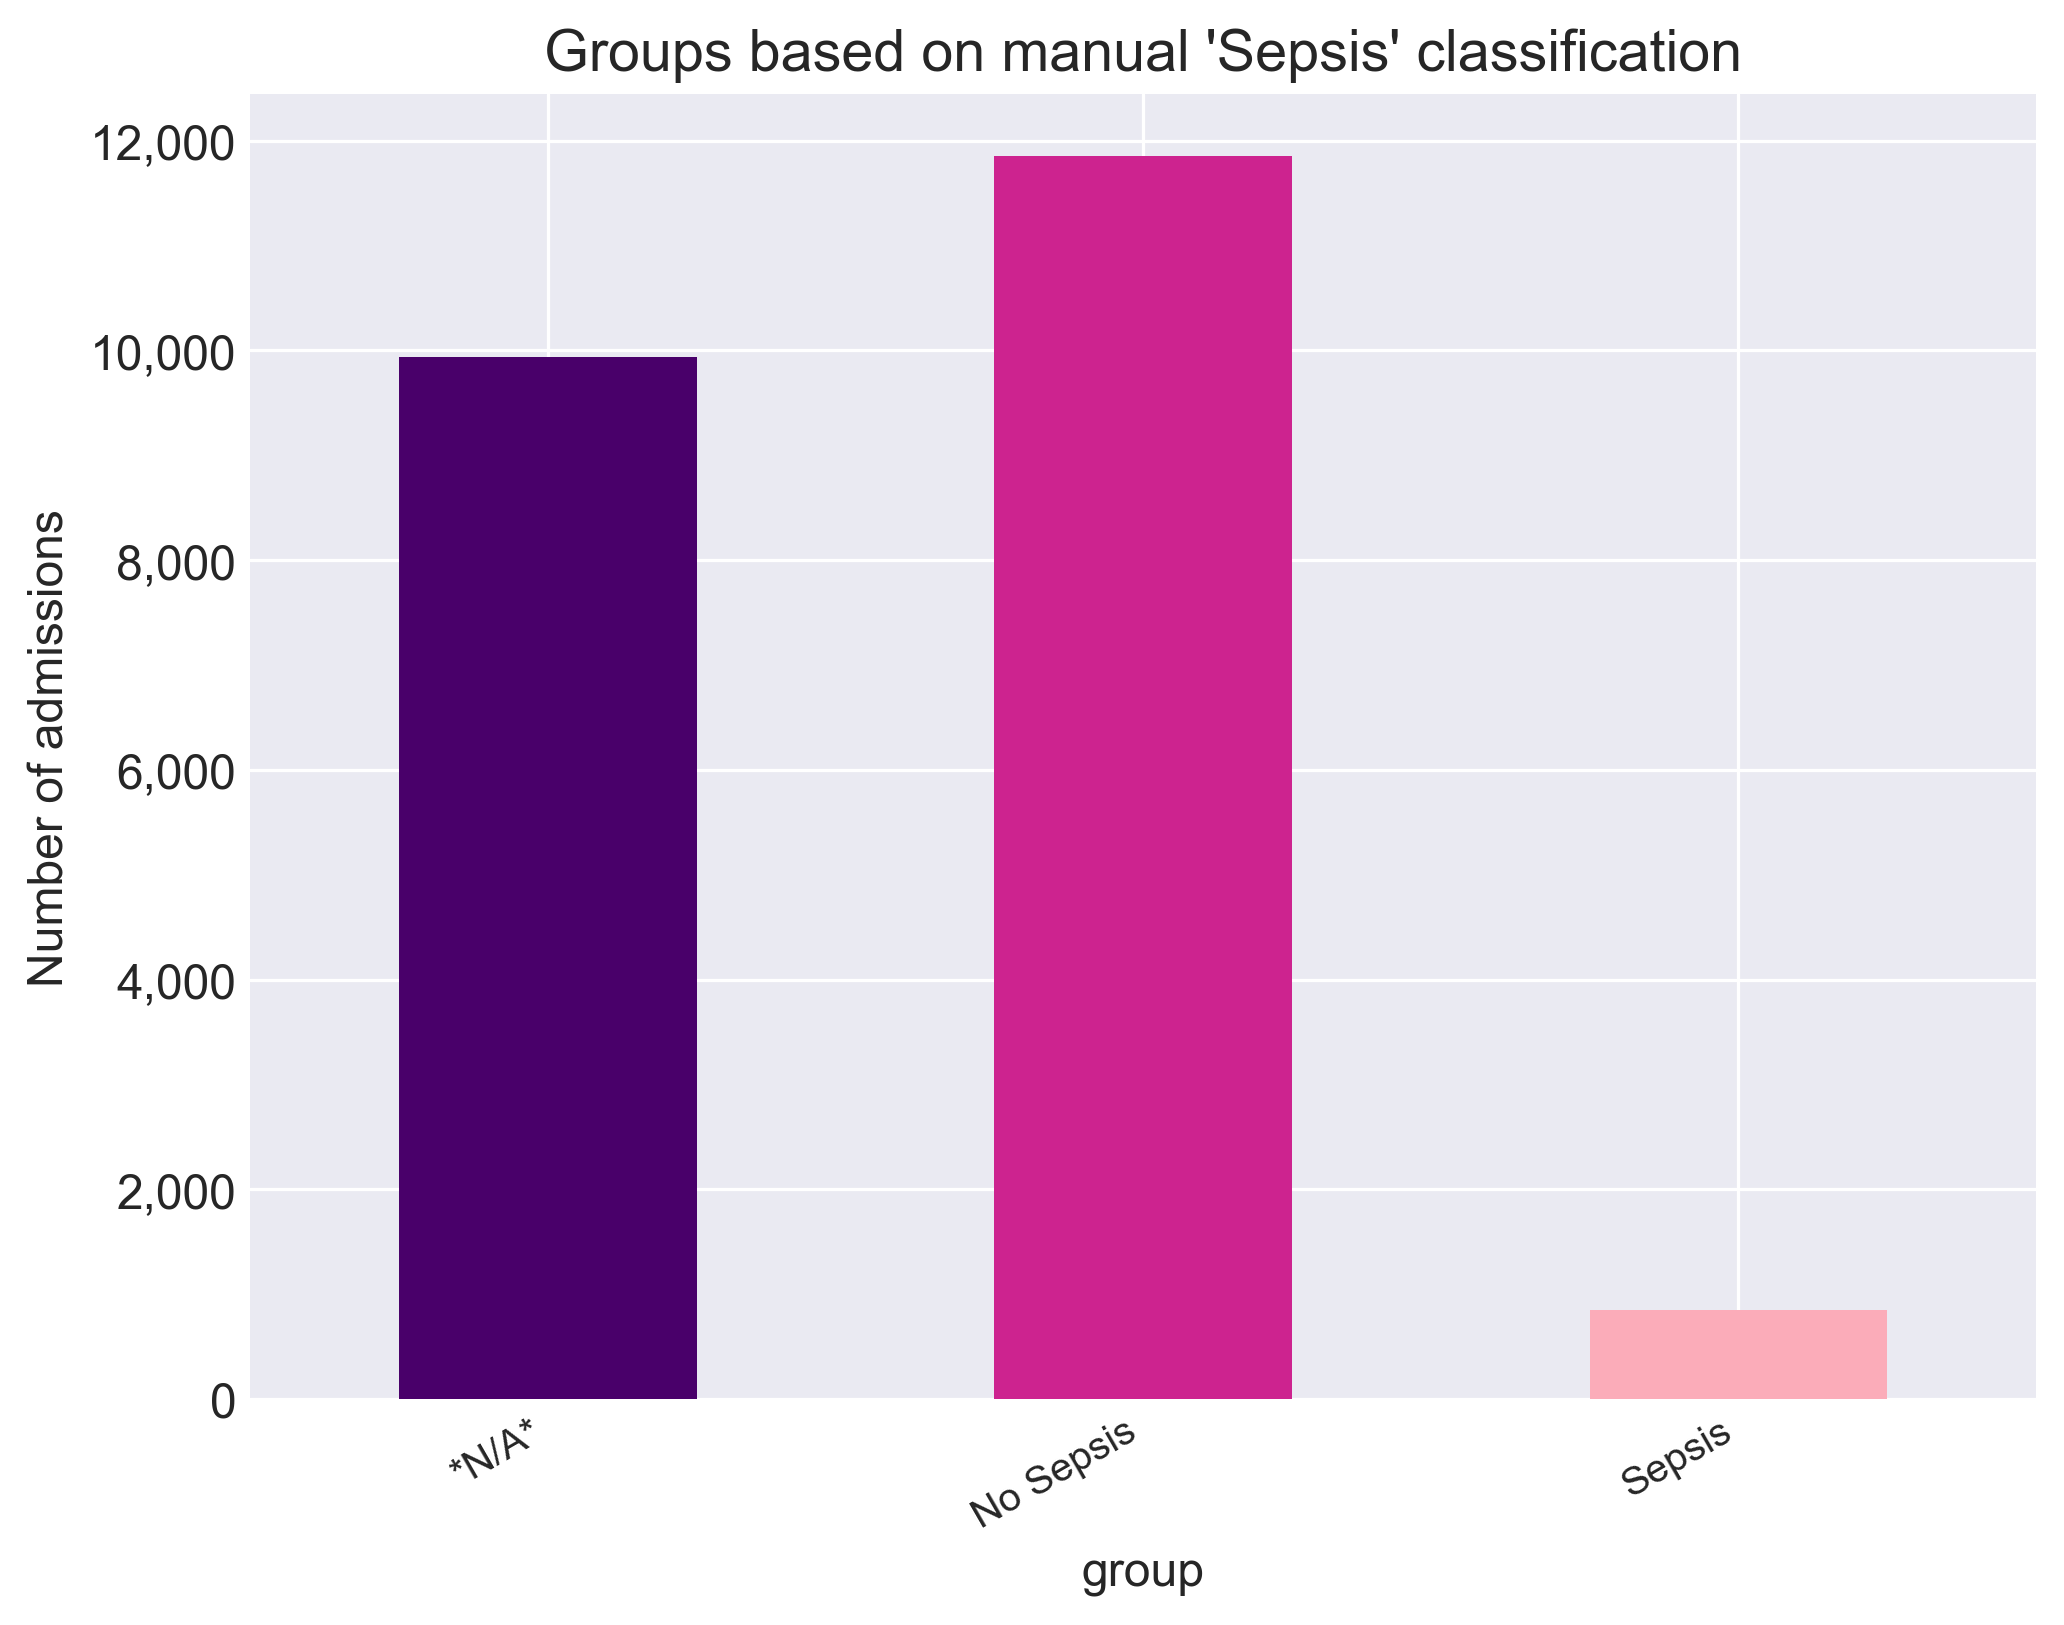

In [25]:
#plot the data
cm = plt.get_cmap('RdPu')
color_step = int(-255/len(plotdata))
ax = plotdata.plot.bar(x=plotdata.columns[0],y=plotdata.columns[1], legend=False,color=cm(range(255,1,color_step)))
ax.set(title='Groups based on manual \'Sepsis\' classification', ylabel=plotdata.columns[1])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=30, horizontalalignment='right',fontweight='light',fontsize='small')

## APACHE II or IV admission diagnosis

In [26]:
#show the most recent documented Apache II or IV diagnosis
sql = """
SET SCHEMA 'amsterdamumcdb';
WITH apache AS (
    SELECT admissionid,
        item AS apache_group, 
        value AS apache_diagnosis,
        CASE 
            WHEN item ILIKE '%non-operat%' THEN 0
            ELSE 1
        END AS surgical,
        ROW_NUMBER() OVER(PARTITION BY admissionid
        ORDER BY measuredat DESC) AS rownum --prioritize APACHE IV over APACHE II
    FROM listitems
   WHERE itemid IN (
        --18588, --Apache II Hoofdgroep
        18589, --Apache II Non-Operatief Cardiovasculair
        18590, --Apache II Non-Operatief Gastro-intestinaal
        18591, --Apache II Non-Operatief Hematologisch
        18592, --Apache II Non-Operatief Metabolisme
        18593, --Apache II Non-Operatief Neurologisch
        18594, --Apache II Non-Operatief Renaal
        18595, --Apache II Non-Operatief Respiratoir
        18596, --Apache II Operatief  Gastr-intenstinaal
        18597, --Apache II Operatief Cardiovasculair
        18598, --Apache II Operatief Hematologisch
        18599, --Apache II Operatief Metabolisme
        18600, --Apache II Operatief Neurologisch
        18601, --Apache II Operatief Renaal
        18602, --Apache II Operatief Respiratoir
        --16997, --APACHE IV Groepen
        16998, --APACHE IV Non-operative cardiovascular
        16999, --APACHE IV Non-operative Gastro-intestinal
        17000, --APACHE IV Non-operative genitourinary
        17001, --APACHEIV  Non-operative haematological
        17002, --APACHEIV  Non-operative metabolic
        17003, --APACHEIV Non-operative musculo-skeletal
        17004, --APACHEIV Non-operative neurologic
        17005, --APACHEIV Non-operative respiratory
        17006, --APACHEIV Non-operative transplant
        17007, --APACHEIV Non-operative trauma
        17008, --APACHEIV Post-operative cardiovascular
        17009, --APACHEIV Post-operative gastro-intestinal
        17010, --APACHEIV Post-operative genitourinary
        17011, --APACHEIV Post-operative hematology
        17012, --APACHEIV Post-operative metabolic
        17013, --APACHEIV Post-operative musculoskeletal /skin
        17014, --APACHEIV Post-operative neurologic
        17015, --APACHEIV Post-operative respiratory
        17016, --APACHEIV Post-operative transplant
        17017 --APACHEIV Post-operative trauma
        
        --- IGNORE Secondary Apache diagnoses and 'NICE'
        --18669, --NICE APACHEII diagnosen
        --18671, --NICE APACHEIV diagnosen
        --18670, --NICE SEC APACHEII diagnosen
        --18673, --NICE SEC APACHEIV diagnosen
        --18603, --SEC_Apache II Hoofdgroep
        --18604, --SEC_Apache II Non-Operatief Cardiovasculair
        --18605, --SEC_Apache II Non-Operatief Gastro-intestinaal
        --18606, --SEC_Apache II Non-Operatief Hematologisch
        --18607, --SEC_Apache II Non-Operatief Metabolisme
        --18608, --SEC_Apache II Non-Operatief Neurologisch
        --18609, --SEC_Apache II Non-Operatief Renaal
        --18610, --SEC_Apache II Non-Operatief Respiratoir
        --18611, --SEC_Apache II Operatief  Gastr-intenstinaal
        --18612, --SEC_Apache II Operatief Cardiovasculair
        --18613, --SEC_Apache II Operatief Hematologisch
        --18614, --SEC_Apache II Operatief Metabolisme
        --18615, --SEC_Apache II Operatief Neurologisch
        --18616, --SEC_Apache II Operatief Renaal
        --18617, --SEC_Apache II Operatief Respiratoir
        --17018, --SEC_APACHE IV Groepen
        --17019, --SEC_APACHE IV Non-operative cardiovascular
        --17020, --SEC_APACHE IV Non-operative Gastro-intestinal
        --17021, --SEC_APACHE IV Non-operative genitourinary
        --17022, --SEC_APACHEIV  Non-operative haematological
        --17023, --SEC_APACHEIV  Non-operative metabolic
        --17024, --SEC_APACHEIV Non-operative musculo-skeletal
        --17025, --SEC_APACHEIV Non-operative neurologic
        --17026, --SEC_APACHEIV Non-operative respiratory
        --17027, --SEC_APACHEIV Non-operative transplant
        --17028, --SEC_APACHEIV Non-operative trauma
        --17029, --SEC_APACHEIV Post-operative cardiovascular
        --17030, --SEC_APACHEIV Post-operative gastro-intestinal
        --17031, --SEC_APACHEIV Post-operative genitourinary
        --17032, --SEC_APACHEIV Post-operative hematology
        --17033, --SEC_APACHEIV Post-operative metabolic
        --17034, --SEC_APACHEIV Post-operative musculoskeletal /skin
        --17035, --SEC_APACHEIV Post-operative neurologic
        --17036, --SEC_APACHEIV Post-operative respiratory
        --17037, --SEC_APACHEIV Post-operative transplant
        --17038 --SEC_APACHEIV Post-operative trauma
        ) 
    )
    
SELECT admissionyeargroup AS "admission year", Count(*) AS "number of patients", 
    Count(apache_diagnosis) AS "available APACHE II/IV diagnoses", Count(*) - Count(apache_diagnosis) AS "*N/A*"
FROM admissions
LEFT JOIN apache on admissions.admissionid = apache.admissionid
WHERE rownum = 1 OR rownum IS NULL --only last updated record, APACHE IV prioritized over APACHE II
GROUP BY ROLLUP(admissionyeargroup)
ORDER BY admissionyeargroup;
"""
admissiondiagnosis = pd.read_sql(sql,con)
admissiondiagnosis

,admission year,number of patients,available APACHE II/IV diagnoses,*N/A*
0,2003-2009,9936,164,9772
1,2010-2016,13236,8764,4472
2,None,23172,8928,14244


(array([0, 1]), <a list of 2 Text xticklabel objects>)

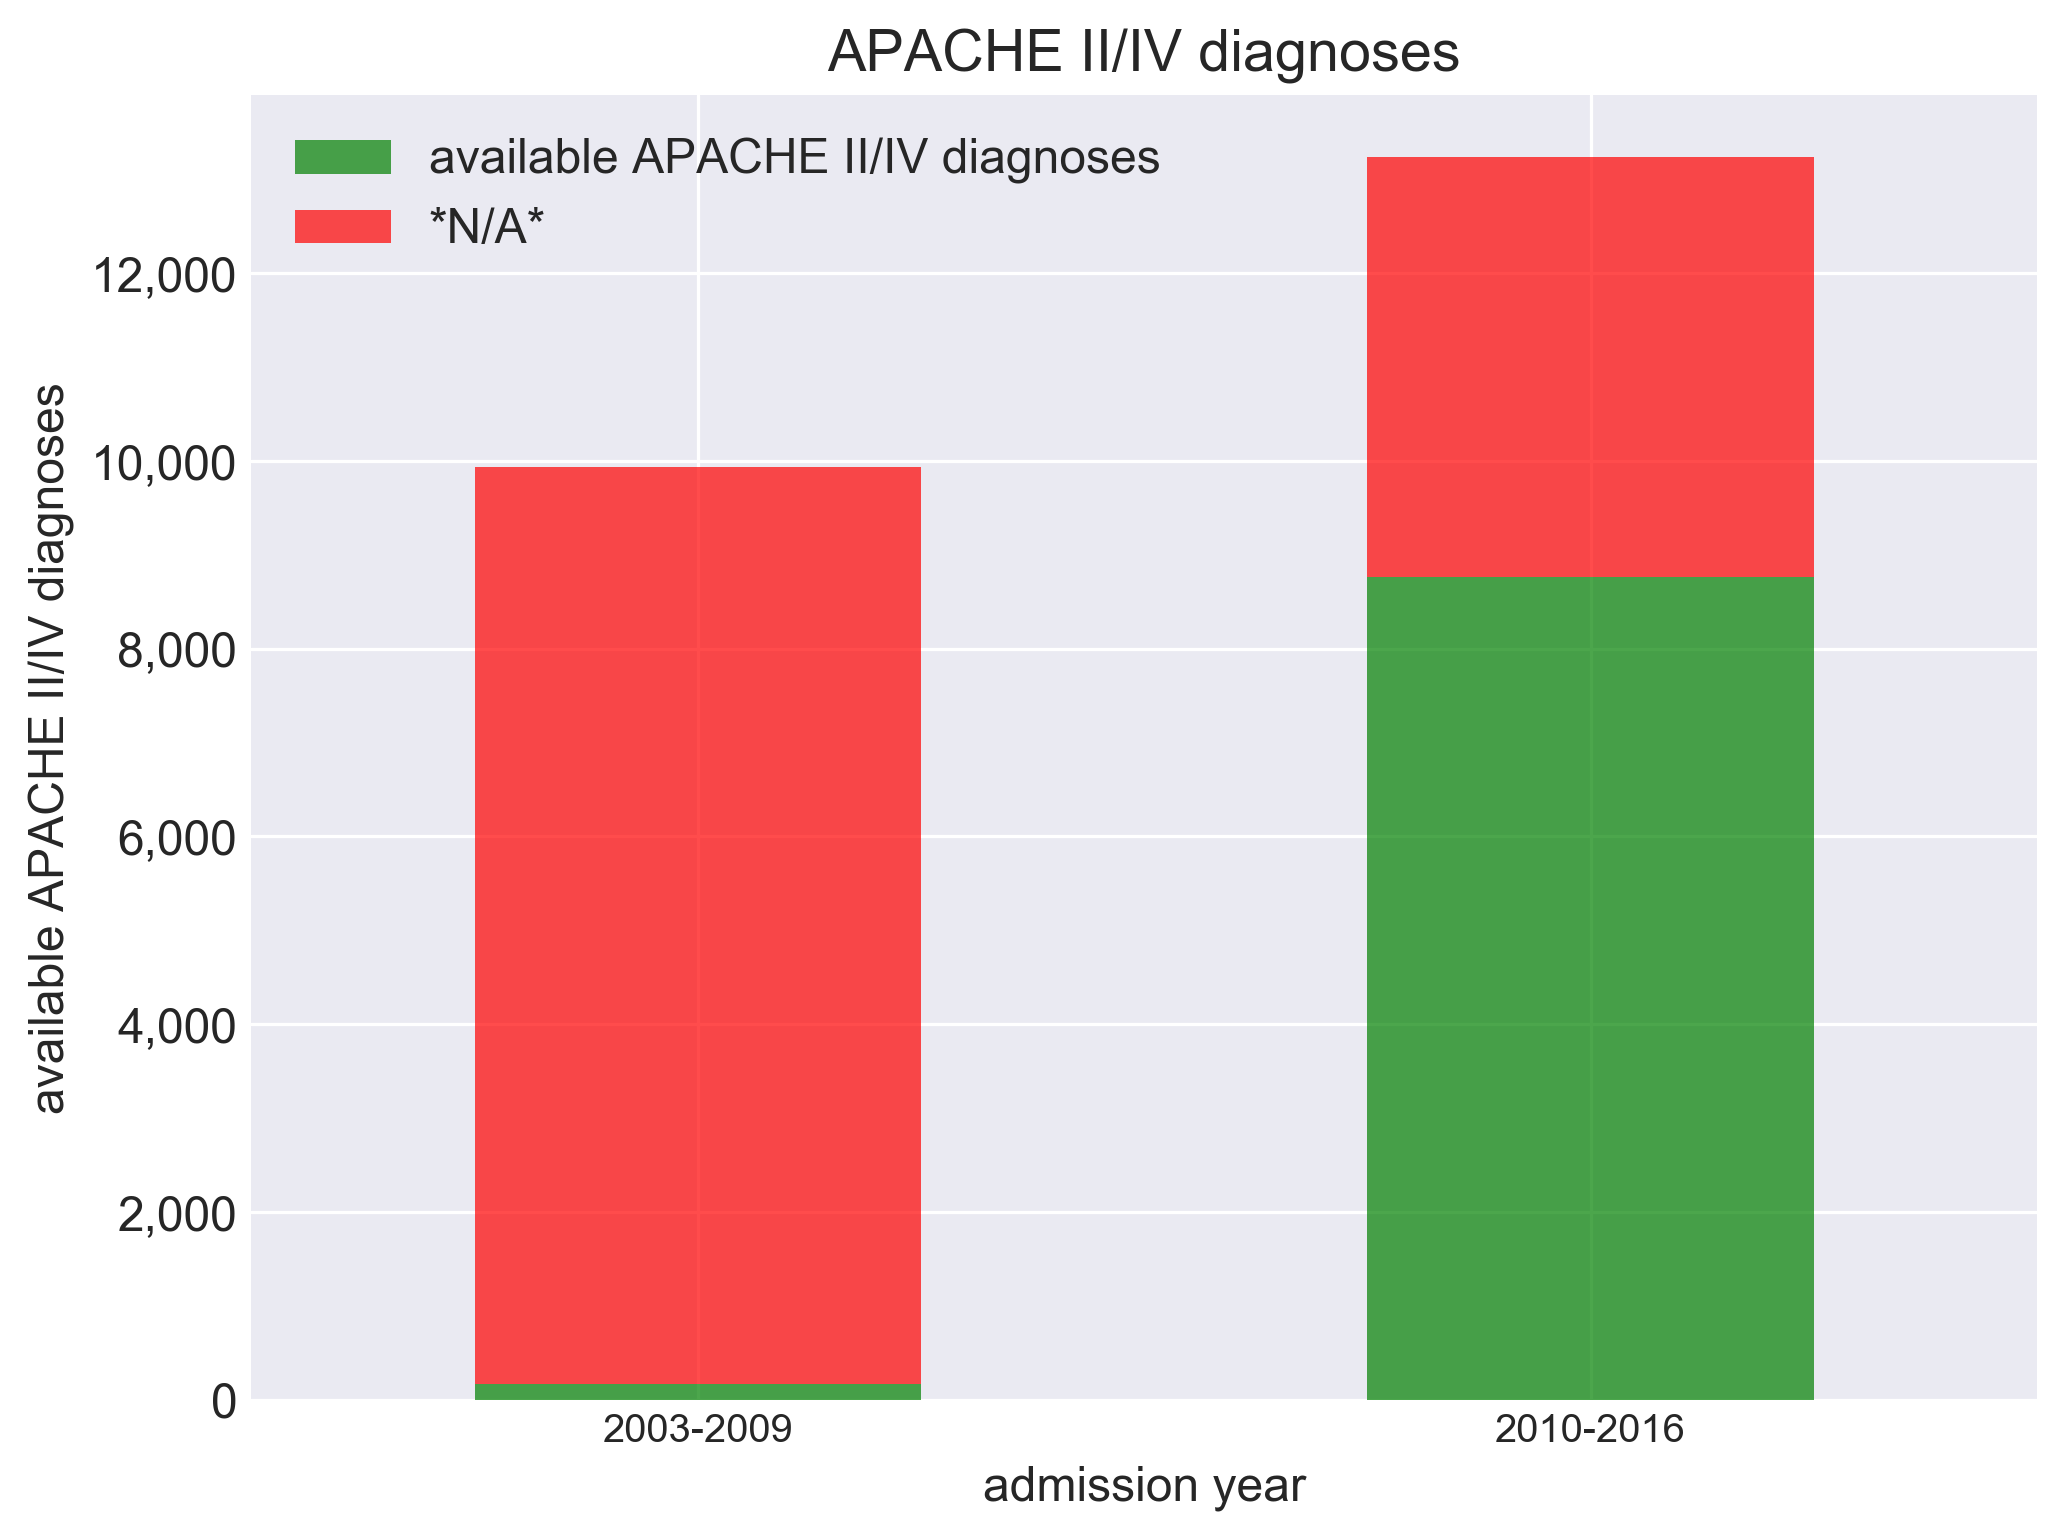

In [27]:
#plot the data
plotdata  = admissiondiagnosis[['admission year','available APACHE II/IV diagnoses', '*N/A*']].iloc[0:-1]
cm = plt.get_cmap('RdPu')
color_step = int(-255/len(plotdata.index))
ax = plotdata.plot.bar(x=plotdata.columns[0],y=plotdata.columns[[1,2]], stacked=True, legend=True,color=['g','r'], alpha=0.70)
ax.set(title='APACHE II/IV diagnoses', xlabel=plotdata.columns[0], ylabel=plotdata.columns[1])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=0, horizontalalignment='center',fontweight='light',fontsize='small')

### APACHE II or IV surgical admissions

In [28]:
#show the most recent documented Apache II or IV diagnosis
sql = """
SET SCHEMA 'amsterdamumcdb';
WITH apache AS (
    SELECT admissionid,
        item AS apache_group, 
        value AS apache_diagnosis,
        CASE 
            WHEN item ILIKE '%non-operat%' THEN 0
            ELSE 1
        END AS surgical,
        ROW_NUMBER() OVER(PARTITION BY admissionid
        ORDER BY measuredat DESC) AS rownum --prioritize APACHE IV over APACHE II
    FROM listitems
   WHERE itemid IN (
        --18588, --Apache II Hoofdgroep
        18589, --Apache II Non-Operatief Cardiovasculair
        18590, --Apache II Non-Operatief Gastro-intestinaal
        18591, --Apache II Non-Operatief Hematologisch
        18592, --Apache II Non-Operatief Metabolisme
        18593, --Apache II Non-Operatief Neurologisch
        18594, --Apache II Non-Operatief Renaal
        18595, --Apache II Non-Operatief Respiratoir
        18596, --Apache II Operatief  Gastr-intenstinaal
        18597, --Apache II Operatief Cardiovasculair
        18598, --Apache II Operatief Hematologisch
        18599, --Apache II Operatief Metabolisme
        18600, --Apache II Operatief Neurologisch
        18601, --Apache II Operatief Renaal
        18602, --Apache II Operatief Respiratoir
        --16997, --APACHE IV Groepen
        16998, --APACHE IV Non-operative cardiovascular
        16999, --APACHE IV Non-operative Gastro-intestinal
        17000, --APACHE IV Non-operative genitourinary
        17001, --APACHEIV  Non-operative haematological
        17002, --APACHEIV  Non-operative metabolic
        17003, --APACHEIV Non-operative musculo-skeletal
        17004, --APACHEIV Non-operative neurologic
        17005, --APACHEIV Non-operative respiratory
        17006, --APACHEIV Non-operative transplant
        17007, --APACHEIV Non-operative trauma
        17008, --APACHEIV Post-operative cardiovascular
        17009, --APACHEIV Post-operative gastro-intestinal
        17010, --APACHEIV Post-operative genitourinary
        17011, --APACHEIV Post-operative hematology
        17012, --APACHEIV Post-operative metabolic
        17013, --APACHEIV Post-operative musculoskeletal /skin
        17014, --APACHEIV Post-operative neurologic
        17015, --APACHEIV Post-operative respiratory
        17016, --APACHEIV Post-operative transplant
        17017 --APACHEIV Post-operative trauma
        
        --- IGNORE Secondary Apache diagnoses and 'NICE'
        --18669, --NICE APACHEII diagnosen
        --18671, --NICE APACHEIV diagnosen
        --18670, --NICE SEC APACHEII diagnosen
        --18673, --NICE SEC APACHEIV diagnosen
        --18603, --SEC_Apache II Hoofdgroep
        --18604, --SEC_Apache II Non-Operatief Cardiovasculair
        --18605, --SEC_Apache II Non-Operatief Gastro-intestinaal
        --18606, --SEC_Apache II Non-Operatief Hematologisch
        --18607, --SEC_Apache II Non-Operatief Metabolisme
        --18608, --SEC_Apache II Non-Operatief Neurologisch
        --18609, --SEC_Apache II Non-Operatief Renaal
        --18610, --SEC_Apache II Non-Operatief Respiratoir
        --18611, --SEC_Apache II Operatief  Gastr-intenstinaal
        --18612, --SEC_Apache II Operatief Cardiovasculair
        --18613, --SEC_Apache II Operatief Hematologisch
        --18614, --SEC_Apache II Operatief Metabolisme
        --18615, --SEC_Apache II Operatief Neurologisch
        --18616, --SEC_Apache II Operatief Renaal
        --18617, --SEC_Apache II Operatief Respiratoir
        --17018, --SEC_APACHE IV Groepen
        --17019, --SEC_APACHE IV Non-operative cardiovascular
        --17020, --SEC_APACHE IV Non-operative Gastro-intestinal
        --17021, --SEC_APACHE IV Non-operative genitourinary
        --17022, --SEC_APACHEIV  Non-operative haematological
        --17023, --SEC_APACHEIV  Non-operative metabolic
        --17024, --SEC_APACHEIV Non-operative musculo-skeletal
        --17025, --SEC_APACHEIV Non-operative neurologic
        --17026, --SEC_APACHEIV Non-operative respiratory
        --17027, --SEC_APACHEIV Non-operative transplant
        --17028, --SEC_APACHEIV Non-operative trauma
        --17029, --SEC_APACHEIV Post-operative cardiovascular
        --17030, --SEC_APACHEIV Post-operative gastro-intestinal
        --17031, --SEC_APACHEIV Post-operative genitourinary
        --17032, --SEC_APACHEIV Post-operative hematology
        --17033, --SEC_APACHEIV Post-operative metabolic
        --17034, --SEC_APACHEIV Post-operative musculoskeletal /skin
        --17035, --SEC_APACHEIV Post-operative neurologic
        --17036, --SEC_APACHEIV Post-operative respiratory
        --17037, --SEC_APACHEIV Post-operative transplant
        --17038 --SEC_APACHEIV Post-operative trauma
        ) 
    )
    
SELECT admissionyeargroup AS "admission year", apache_diagnosis, surgical
FROM admissions
LEFT JOIN apache on admissions.admissionid = apache.admissionid
WHERE rownum = 1 OR rownum IS NULL --only last updated record, APACHE IV prioritized over APACHE II
"""
admissiondiagnosis = pd.read_sql(sql,con)
admissiondiagnosis.head(10)

,admission year,apache_diagnosis,surgical
0,2010-2016,CABG with aortic valve replacement,1.0
1,2010-2016,"CABG alone, coronary artery bypass grafting",1.0
2,2010-2016,"Restrictive lung disease (i.e. sarcoidosis, pulmonary fibrosis)",0.0
3,2010-2016,Shunts and revisions,1.0
4,2010-2016,Cystectomy for neoplasm,1.0
5,2010-2016,Na cardiac arrest,0.0
6,2010-2016,Whipple-surgery for pancreatic cancer,1.0
7,2010-2016,Cardiac arrest (with or without respiratory arrest;,0.0
8,2010-2016,Na cardiac arrest,0.0
9,2010-2016,"CABG alone, coronary artery bypass grafting",1.0


In [29]:
surgical = admissiondiagnosis[admissiondiagnosis['surgical'] == 1].groupby('apache_diagnosis').size().to_frame('number of admissions').sort_values('number of admissions', ascending=False).reset_index().head(10)
surgical

,apache_diagnosis,number of admissions
0,"CABG alone, coronary artery bypass grafting",895
1,Chron. cardiovasculaire ziekte,638
2,Cardiovasculair,320
3,Hartkleppen,277
4,Aortic valve replacement (isolated),246
5,"Neoplasm-cranial, surgery for (excluding transphenoidal)",179
6,Craniotomie voor neoplasma,141
7,CABG with aortic valve replacement,131
8,Gastro-intestinaal voor neoplasma,122
9,Kidney transplant,104


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

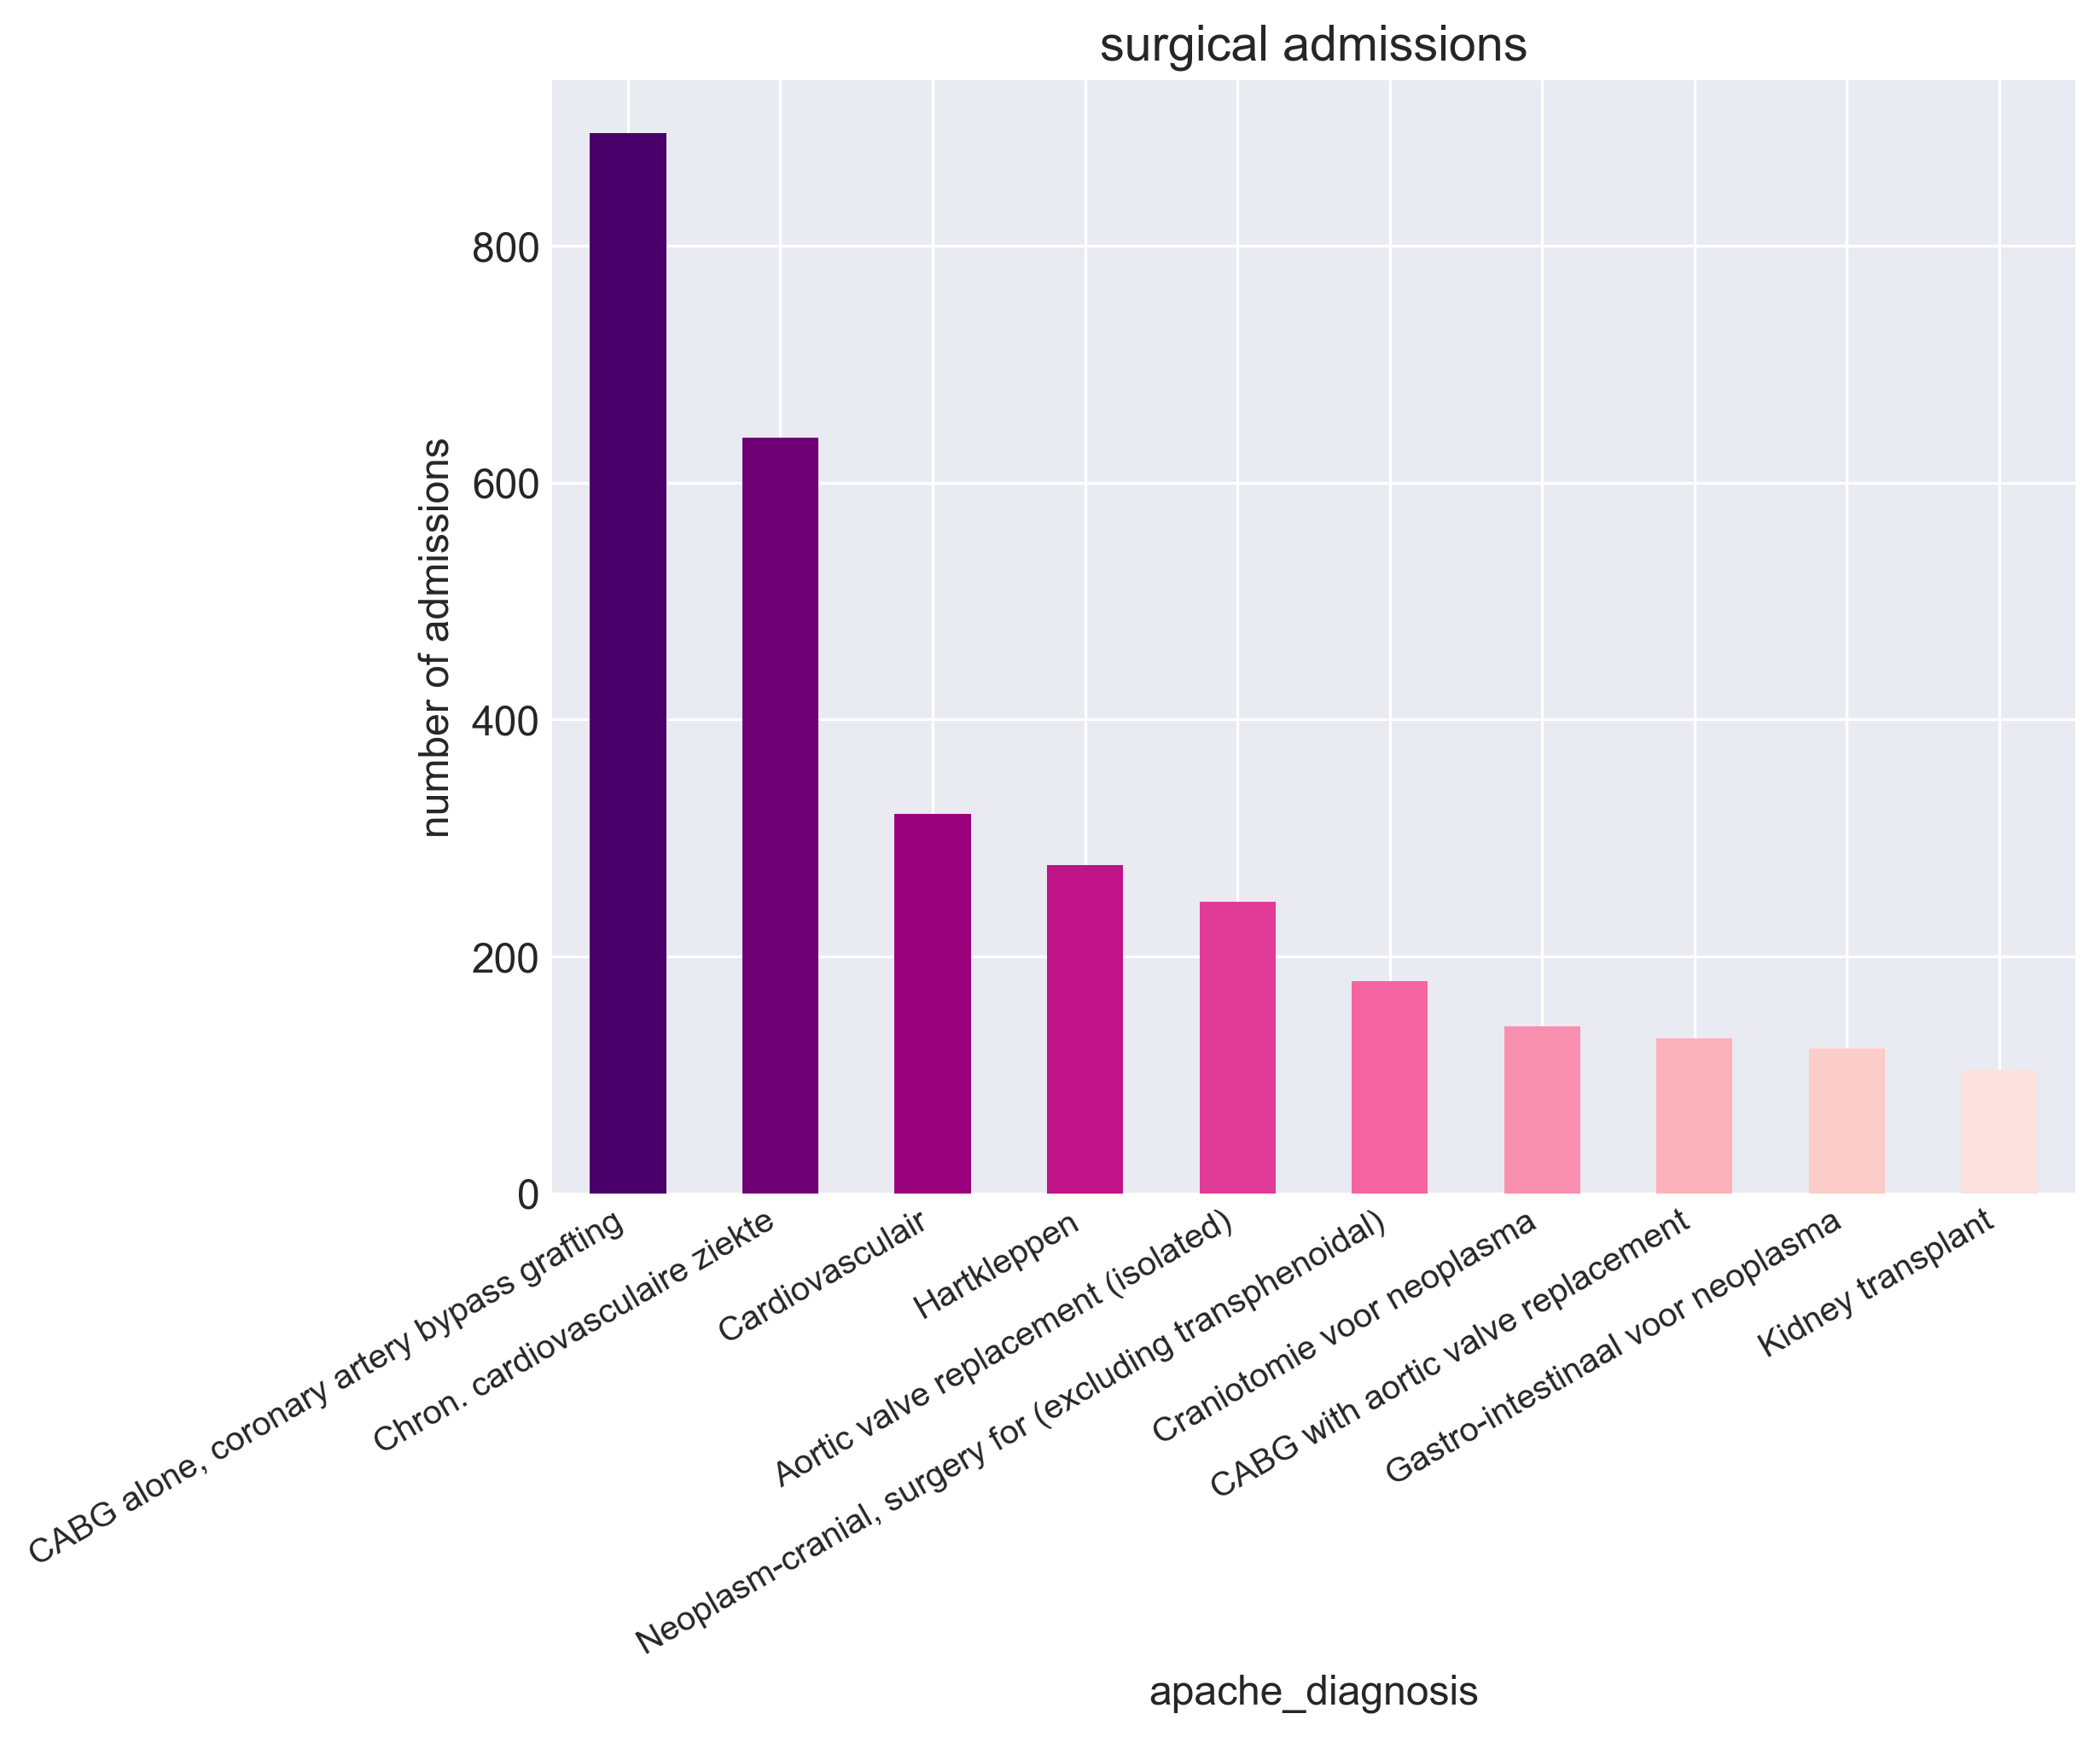

In [30]:
#plot the data
cm = plt.get_cmap('RdPu')
color_step = int(-255/len(surgical.index))
ax = surgical.plot.bar(x=surgical.columns[0],y=surgical.columns[1], legend=False,color=cm(range(255,1,color_step)))
ax.set(title='surgical admissions', ylabel=surgical.columns[1])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=30, horizontalalignment='right',fontweight='light',fontsize='small')

### APACHE II or IV medical admissions

In [31]:
medical = admissiondiagnosis[admissiondiagnosis['surgical'] == 0]
medical.head()

,admission year,apache_diagnosis,surgical
2,2010-2016,"Restrictive lung disease (i.e. sarcoidosis, pulmonary fibrosis)",0.0
5,2010-2016,Na cardiac arrest,0.0
7,2010-2016,Cardiac arrest (with or without respiratory arrest;,0.0
8,2010-2016,Na cardiac arrest,0.0
11,2010-2016,Haemorragische shock,0.0


In [32]:
medical = admissiondiagnosis[admissiondiagnosis['surgical'] == 0].groupby('apache_diagnosis').size().to_frame('number of admissions').sort_values('number of admissions', ascending=False).reset_index().head(10)
medical

,apache_diagnosis,number of admissions
0,Na cardiac arrest,269
1,Cardiac arrest (with or without respiratory arrest;,240
2,Respiratoir,193
3,Respiratoire infectie,144
4,Sepsis,121
5,"Pneumonia, bacterial",119
6,Neurologisch,100
7,Hoofdtrauma,88
8,"CHF, congestive heart failure",78
9,Congestief hart falen,71


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

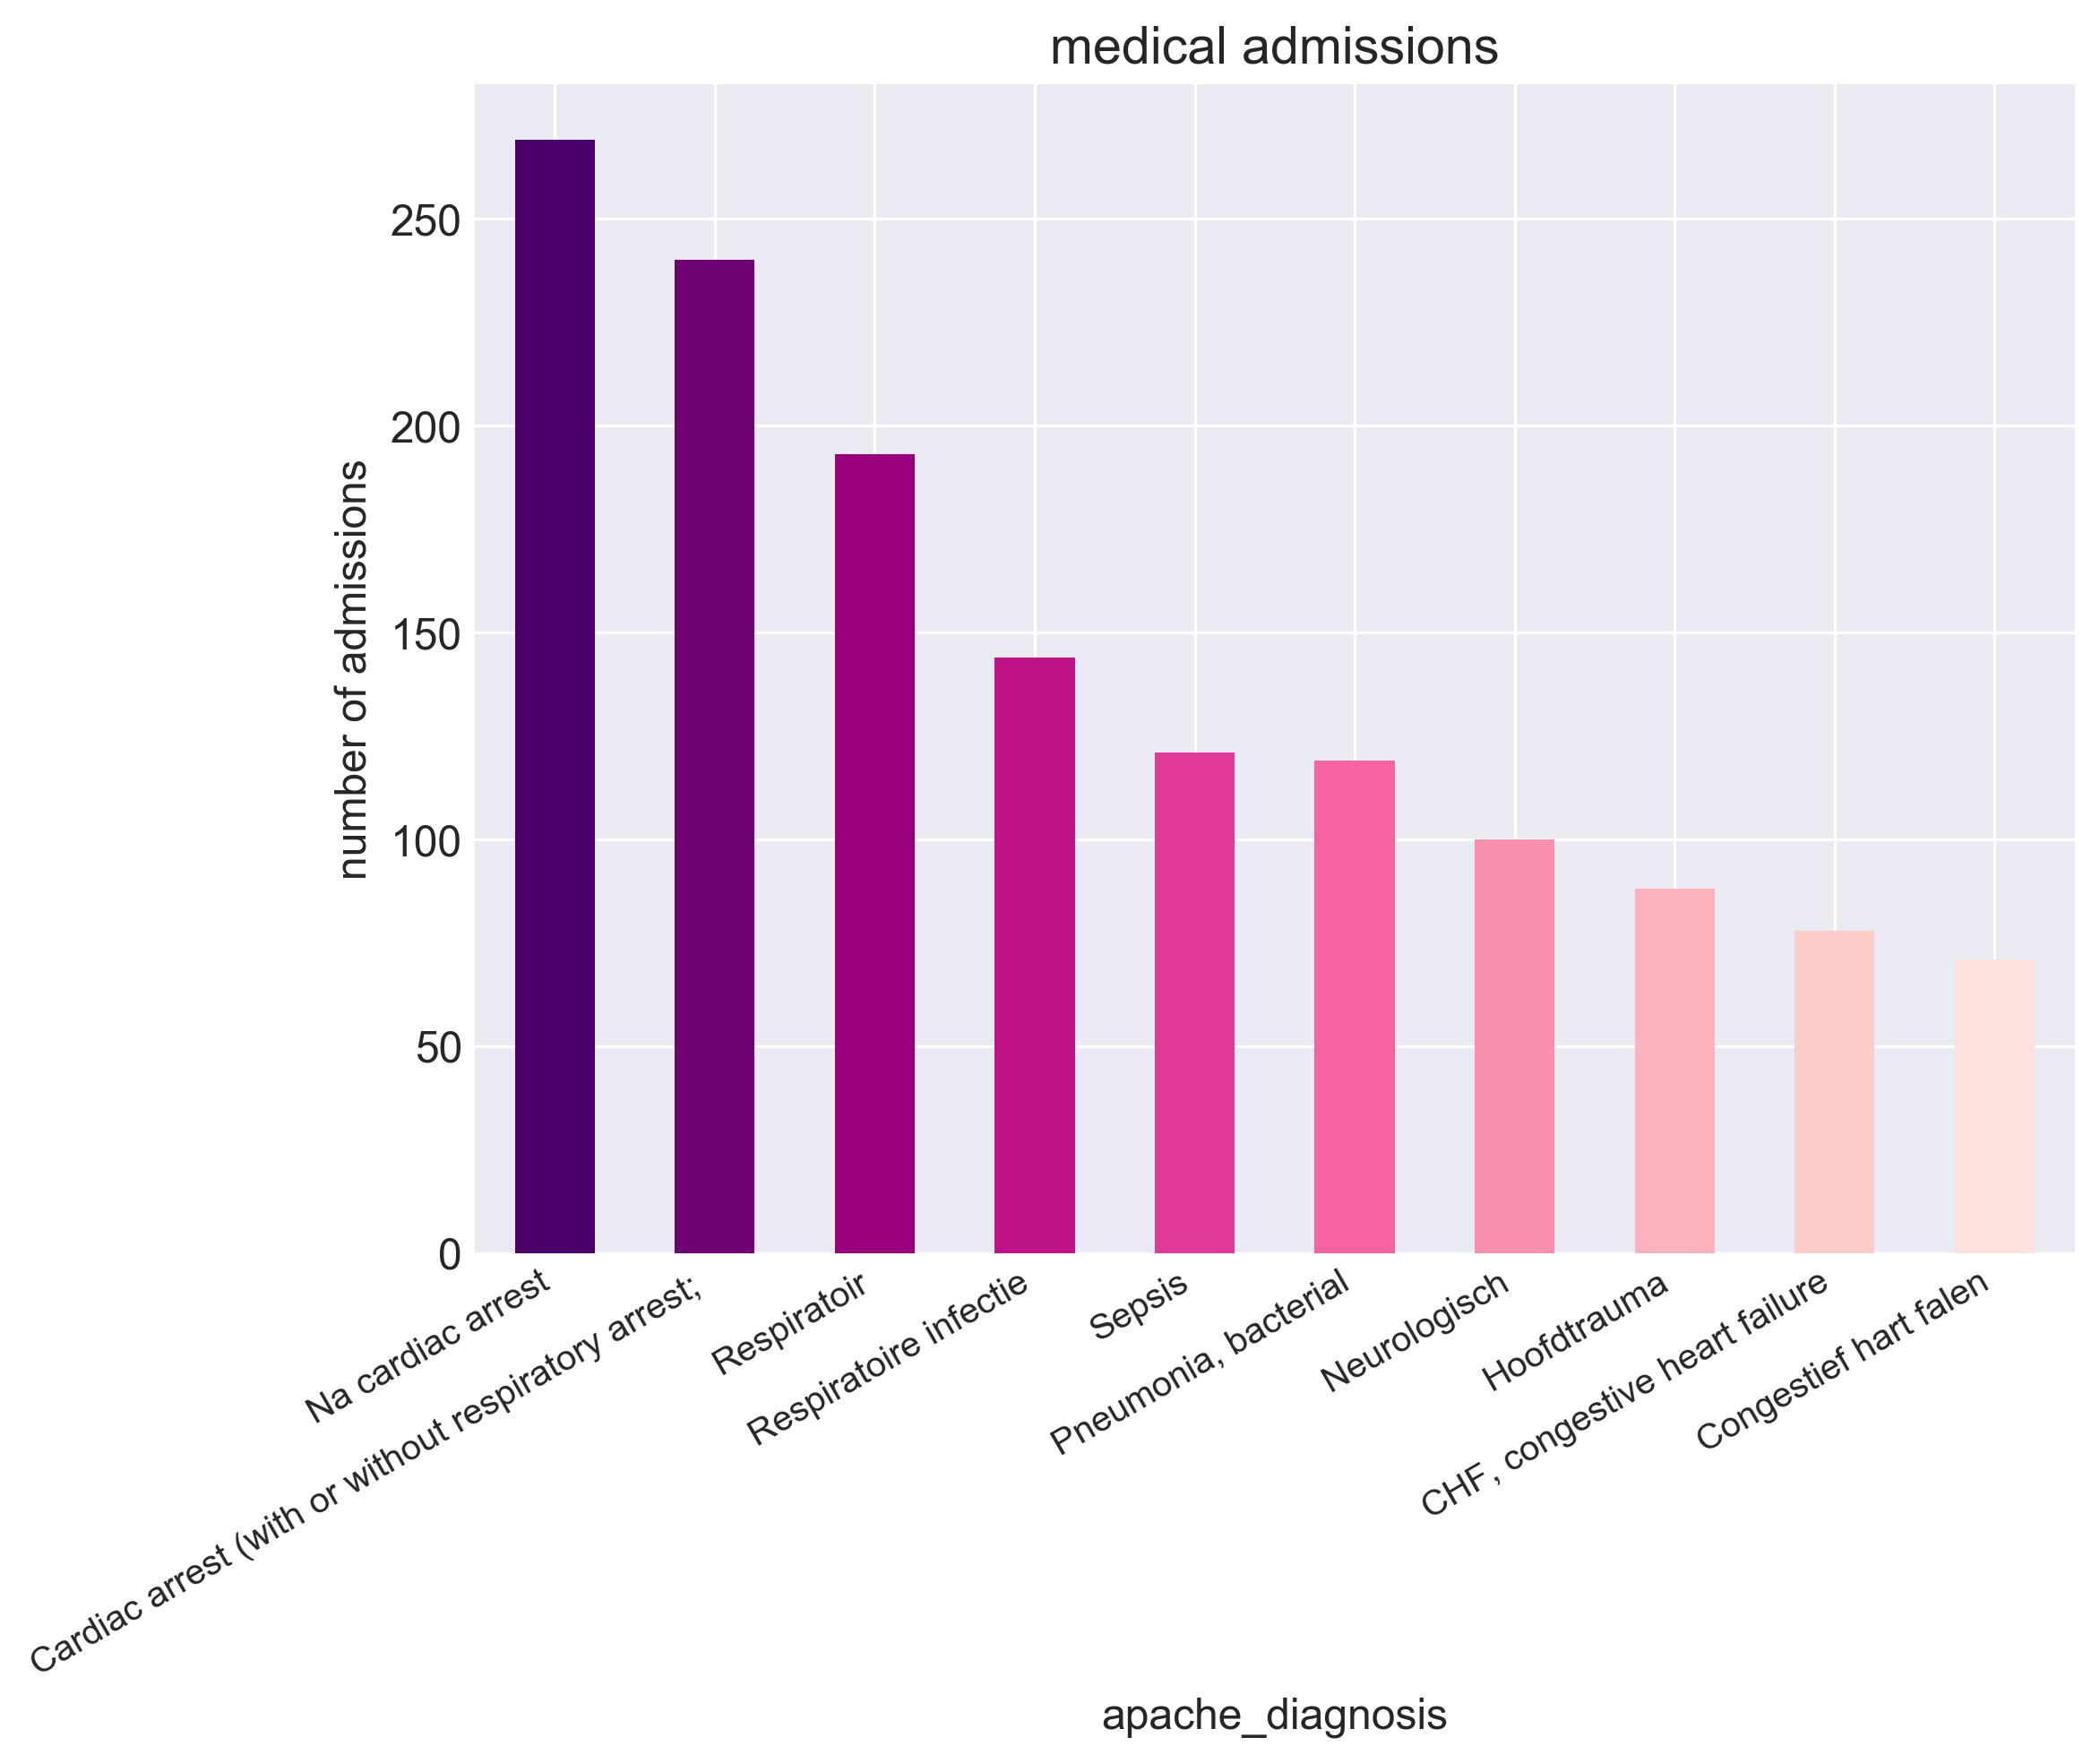

In [33]:
#plot the data
cm = plt.get_cmap('RdPu')
color_step = int(-255/len(medical.index))
ax = medical.plot.bar(x=medical.columns[0],y=medical.columns[1], legend=False,color=cm(range(255,1,color_step)))
ax.set(title='medical admissions', ylabel=medical.columns[1])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=30, horizontalalignment='right',fontweight='light',fontsize='small')

In [34]:
plotdata = admissiondiagnosis[['surgical']].copy()
plotdata.loc[plotdata['surgical'] == 1, 'group'] = 'Surgical'
plotdata.loc[plotdata['surgical'] == 0, 'group'] = 'Medical'
plotdata.loc[plotdata['surgical'].isna(), 'group'] = '*N/A*'
plotdata = plotdata.groupby('group').size().to_frame('Number of admissions').reset_index()
plotdata

,group,Number of admissions
0,*N/A*,14244
1,Medical,3527
2,Surgical,5401


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

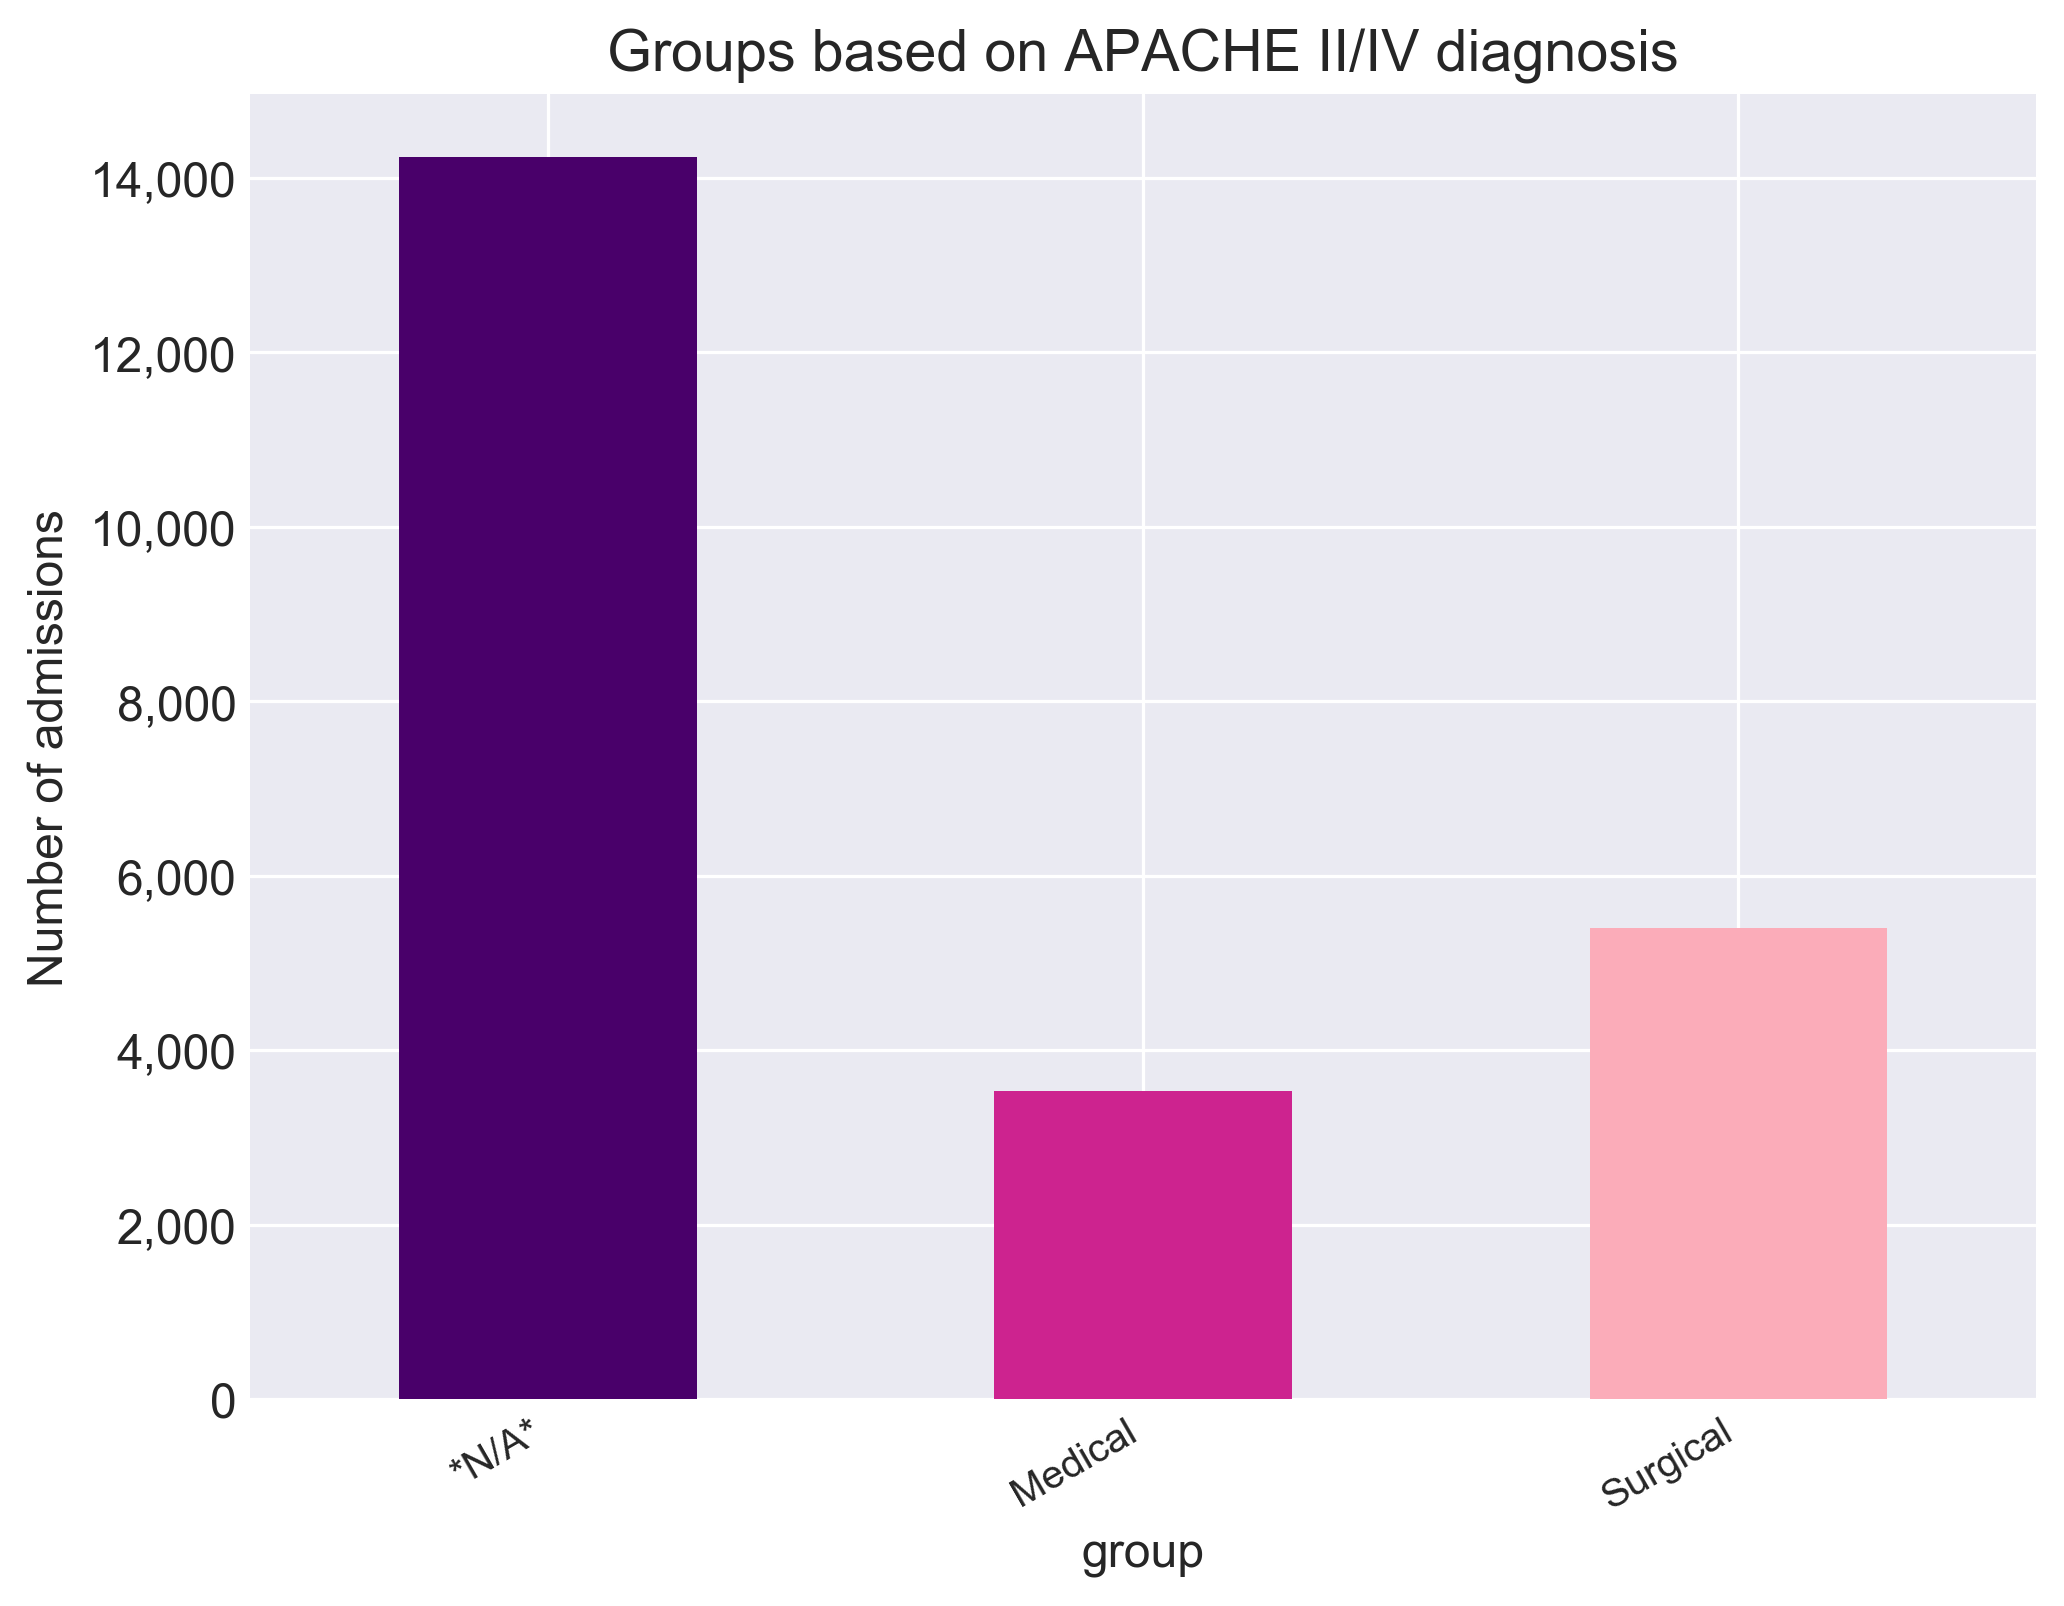

In [35]:
#plot the data
cm = plt.get_cmap('RdPu')
color_step = int(-255/len(plotdata))
ax = plotdata.plot.bar(x=plotdata.columns[0],y=plotdata.columns[1], legend=False,color=cm(range(255,1,color_step)))
ax.set(title='Groups based on APACHE II/IV diagnosis', ylabel=plotdata.columns[1])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=30, horizontalalignment='right',fontweight='light',fontsize='small')